# Initial Setup

In [1]:
%%capture
%load_ext autoreload
%autoreload 2

from tqdm.notebook import trange, tqdm
from random import random
import pandas as pd
import matplotlib
import numpy as np
import csv
import itertools
import pickle as pkl

import time
import datetime
from dateutil.relativedelta import relativedelta
import pandas_market_calendars as mcal
import mplfinance as mpl
# import matplotlib.dates as mdates

import yfinance as yf
from alpha_vantage.timeseries import TimeSeries

from IPython.display import Audio
sound_file = '../sound/done.mp3'
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics(
    ip,
    require_interaction=True
))

import pmdarima as pm
from pmdarima.metrics import smape
from sklearn.metrics import mean_squared_error as mse

import prophet

from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# from pathlib import Path
# import os
# current_path = os.getcwd()
# # top = Path(__file__ + '..').resolve()
import sys, os
code_path = '/code'
auth_path = '/auth'
if '..' + code_path not in sys.path:
    sys.path.insert(0, '..' + code_path)
if '..' + auth_path not in sys.path:
    sys.path.insert(0, '..' + auth_path)
current_path = os.getcwd()
sys.path
# sys.path.insert(0, top/ 'code')
# sys.path.insert(0, top/ 'auth')
# sys.path.insert(0, '../code')
# sys.path.insert(0, '../auth')
# sys.path.insert(0, '../')

# arrow = top / 'assets/arrow.png'
# print('source image:', arrow)

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
# plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

%matplotlib inline
font = {'size'   : 14}
matplotlib.rc('font', **font)

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',50)

from functions import *
from Pmdarima_Model import Pmdarima_Model
# from Pmdarima_Model_En_Ex import Pmdarima_Model_En_Ex

# only display whole years in figures
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')

from keys import client_id, secret_key, av_key, consumer_key

## Get NYSE calendar

In [2]:
NYSE = mcal.get_calendar('NYSE')
early = NYSE.schedule(start_date='2012-07-01', end_date='2012-07-10')
early;

## Set up Frequency Variables

### Custom Business Hour

In [3]:
cbh = pd.offsets.CustomBusinessHour(calendar=NYSE, start='05:00', end='21:00')
cbh

<CustomBusinessHour: CBH=05:00-21:00>

### Custom Business Day

In [4]:
%notify
cbd = pd.offsets.CustomBusinessDay(calendar=NYSE)
cbd

<IPython.core.display.Javascript object>

<CustomBusinessDay>

# YFinance

## Setup / Gather Data

In [5]:
ticker = 'SPY'
YF_COLUMNS = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

In [6]:
# def download_time_series(yf, years, ticker):
#     for year in years:
#         start_year = pd.Timestamp.today().year - year
#         start_date = pd.to_datetime(f'{start_year}-05-01')
#         start_file = start_date if cbd.is_on_offset(start_date) else (start_date+cbd).date()
#         end_date = pd.Timestamp.today()
#         end_file = (end_date - cbd).date()
        
#         df = yf.download(ticker, start=start_date, end=end_date, progress=False)
#         df.index = df.index.rename('date')
#         df.columns = YF_COLUMNS
#         df.to_csv(f'../data/{ticker}_{year}Y_CBD_{start_file}_{end_file}.csv')

In [7]:
years = [3,5,10]
get_yf_time_series(yf, years, ticker, freq=cbd)
# get_yf_time_series(yf, [2], ticker, freq=cbd)

In [8]:
# spy_df = yf.download(ticker, start=start, end=end, progress=False)
# spy_df.index = spy_df.index.rename('date')
# spy_df.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
# spy_df.to_csv(f'../data/SPY_3Y_CBD_{start}_{end-cbd}.csv')

In [9]:
# spy_df = yf.download(ticker, start=start_date, end=end_date, progress=False)
# spy_df.index = spy_df.index.rename('date')
# spy_df.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
# spy_df.to_csv(f'../data/SPY_5Y_CBD_{start_file}_{end_file}.csv')

In [10]:
# spy_df = yf.download(ticker, start='2011-05-01', end='2021-05-01', progress=False)
# spy_df.index = spy_df.index.rename('date')
# spy_df.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
# spy_df.to_csv(f'../data/SPY_10Y_CBD.csv')

## Load Data from File

### 3Y

In [11]:
# def load_yf_time_series(yf, year, ticker):
#     start_year = pd.Timestamp.today().year - year
#     start_date = pd.to_datetime(f'{start_year}-05-01')
#     start_file = start_date if cbd.is_on_offset(start_date) else (start_date+cbd).date()
#     end_date = pd.Timestamp.today()
#     end_file = (end_date - cbd).date()

#     df = pd.read_csv(f'../data/{ticker}_{year}Y_CBD_{start_file}_{end_file}.csv', index_col='date')
#     df.index = pd.to_datetime(df.index)
    
#     return df

In [12]:
# spy_df_3Y = pd.read_csv('../data/SPY_3Y_CBD.csv', index_col='date')
# spy_df_3Y.index = pd.to_datetime(spy_df_3Y.index)

In [13]:
spy_df_3Y = load_yf_time_series(yf, 3, ticker, freq=cbd)

### 5Y

In [14]:
# spy_df_5Y = pd.read_csv('../data/SPY_5Y_CBD.csv', index_col='date')
# spy_df_5Y.index = pd.to_datetime(spy_df_5Y.index)
spy_df_5Y = load_yf_time_series(yf, 5, ticker, freq=cbd)

### 10Y

In [15]:
# spy_df_10Y = pd.read_csv('../data/SPY_10Y_CBD.csv', index_col='date')
# spy_df_10Y.index = pd.to_datetime(spy_df_10Y.index)
spy_df_10Y = load_yf_time_series(yf, 10, ticker, freq=cbd)

## Data Preparation

### EDA

In [16]:
spy_df_5Y

,open,high,low,close,adj_close,volume
date,,,,,,
2016-05-02,206.919998,208.179993,206.410004,207.970001,189.178101,62188000
2016-05-03,206.520004,206.800003,205.279999,206.160004,187.531647,106422100
2016-05-04,204.990005,205.850006,204.419998,205.009995,186.485535,92243800
2016-05-05,205.559998,205.979996,204.470001,204.970001,186.449203,67619200
2016-05-06,204.059998,205.770004,203.880005,205.720001,187.131424,89315000
...,...,...,...,...,...,...
2021-04-29,420.320007,420.720001,416.440002,420.059998,420.059998,78544300
2021-04-30,417.630005,418.540009,416.339996,417.299988,417.299988,85448400
2021-05-03,419.429993,419.839996,417.670013,418.200012,418.200012,68128300


In [17]:
spy_df_3Y.isna().sum()

open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

### Set up Frequency

In [18]:
spy_df_3Y = spy_df_3Y.asfreq(cbd)
spy_df_5Y = spy_df_5Y.asfreq(cbd)
spy_df_10Y = spy_df_10Y.asfreq(cbd)

In [19]:
spy_df_5Y.isna().sum()

open         46
high         46
low          46
close        46
adj_close    46
volume       46
dtype: int64

### Remove today's incomplete data (if needed)

In [20]:
# spy_df_3Y.drop(spy_df_3Y.tail(1).index, inplace=True)
# spy_df_5Y.drop(spy_df_5Y.tail(1).index, inplace=True)
# spy_df_10Y.drop(spy_df_10Y.tail(1).index, inplace=True)

### Impute Missing Values

In [21]:
spy_df_3Y = spy_df_3Y.interpolate()
spy_df_5Y = spy_df_5Y.interpolate()
spy_df_10Y = spy_df_10Y.interpolate()

### Create Time Series for `Close`, `Volume`

In [22]:
df_full_3Y_close = spy_df_3Y.close
df_full_3Y_vol = spy_df_3Y.volume
df_full_5Y_close = spy_df_5Y.close
df_full_5Y_vol = spy_df_5Y.volume
df_full_10Y_close = spy_df_10Y.close
df_full_10Y_vol = spy_df_10Y.volume

In [23]:
df_full_5Y_close

date
2016-05-02    207.970001
2016-05-03    206.160004
2016-05-04    205.009995
2016-05-05    204.970001
2016-05-06    205.720001
                 ...    
2021-04-29    420.059998
2021-04-30    417.299988
2021-05-03    418.200012
2021-05-04    415.619995
2021-05-05    415.750000
Freq: C, Name: close, Length: 1308, dtype: float64

In [24]:
df_full_10Y_close, df_full_10Y_vol

(date
 2011-05-02    136.220001
 2011-05-03    135.729996
 2011-05-04    134.830002
 2011-05-05    133.610001
 2011-05-06    134.199997
                  ...    
 2021-04-29    420.059998
 2021-04-30    417.299988
 2021-05-03    418.200012
 2021-05-04    415.619995
 2021-05-05    415.750000
 Freq: C, Name: close, Length: 2613, dtype: float64,
 date
 2011-05-02    126278700.0
 2011-05-03    138375000.0
 2011-05-04    182678500.0
 2011-05-05    226900000.0
 2011-05-06    222787200.0
                  ...     
 2021-04-29     78544300.0
 2021-04-30     85448400.0
 2021-05-03     68128300.0
 2021-05-04    101441600.0
 2021-05-05     54449461.0
 Freq: C, Name: volume, Length: 2613, dtype: float64)

### Create 2D Volume Time Series

In [25]:
df_full_3Y_close.shape

(787,)

In [26]:
vol_3Y_df = pd.DataFrame(df_full_3Y_vol).reset_index()
vol_5Y_df = pd.DataFrame(df_full_5Y_vol).reset_index()
vol_10Y_df = pd.DataFrame(df_full_10Y_vol).reset_index()

### Create Future Dates

In [30]:
today = pd.Timestamp.today()
new_dates = pd.date_range(start=today, periods=5, freq=cbd)

index_3Y_fc = range(df_full_3Y_close.size, df_full_3Y_close.size + 5)
index_5Y_fc = range(df_full_5Y_close.size, df_full_5Y_close.size + 5)
index_10Y_fc = range(df_full_10Y_close.size, df_full_10Y_close.size + 5)

new_dates_3Y_df = pd.DataFrame(new_dates, index=index_3Y_fc, columns=['date'])
new_dates_5Y_df = pd.DataFrame(new_dates, index=index_5Y_fc, columns=['date'])
new_dates_10Y_df = pd.DataFrame(new_dates, index=index_10Y_fc, columns=['date'])

## Plot PACF

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning:

invalid value encountered in sqrt



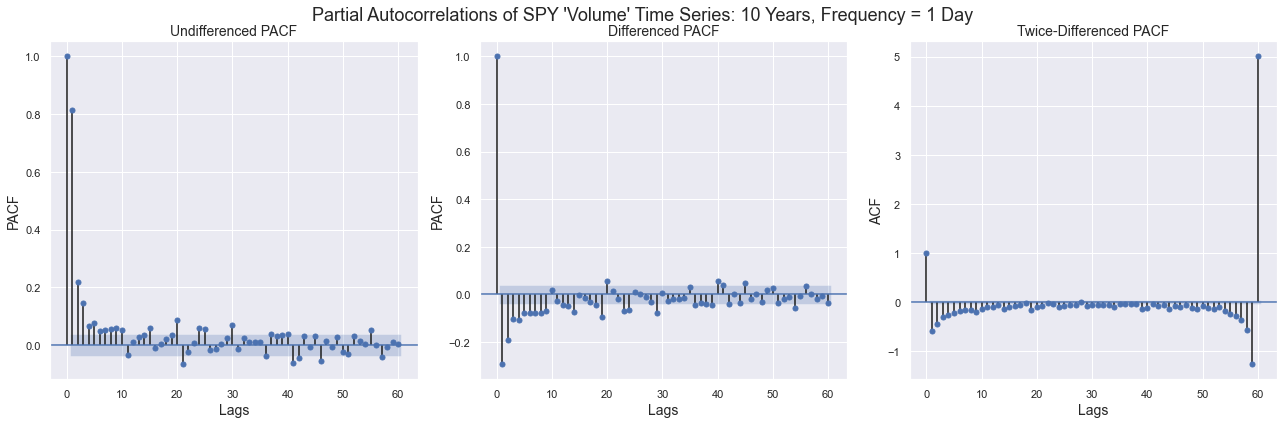

In [255]:
plot_pacf_with_diff(df_full_10Y_vol, 'SPY \'Volume\'', 10, 'years', '1 Day', lags=60)

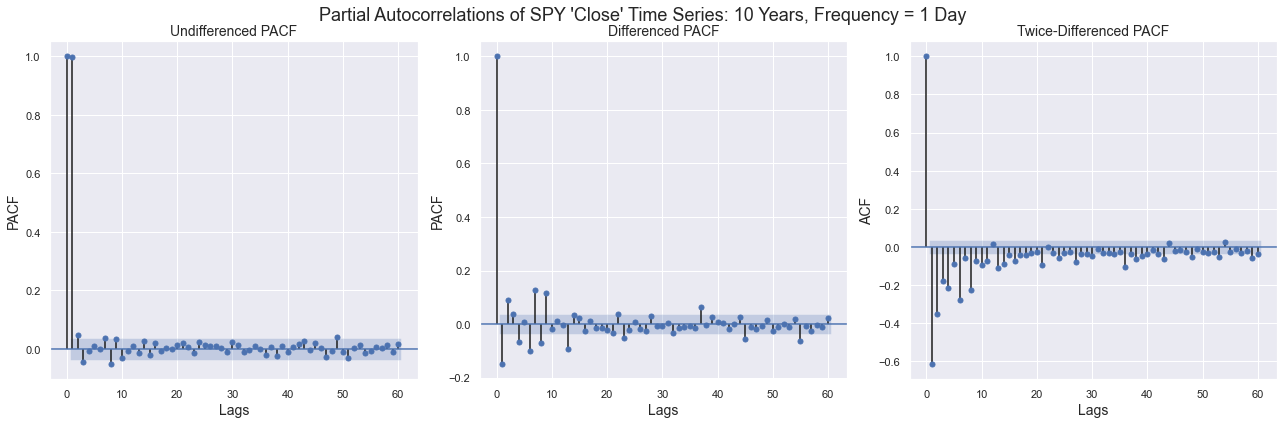

In [257]:
plot_pacf_with_diff(df_full_10Y_close.interpolate(), 'SPY \'Close\'', 10, 'years', '1 Day', lags=60)

## Plot ACF

In [ ]:
plot_acf_with_diff(df_full_3Y_vol, 'SPY \'Volume\'', 3, 'years', '1 Day', lags=60)

In [ ]:
plot_acf_with_diff(df_full_3Y_close, 'SPY \'Close\'', 3, 'years', '1 Day', lags=60)

## Plot Seasonal Decomposition

### 3 Years, Freq = Custom Business Day, Yearly Seasonality

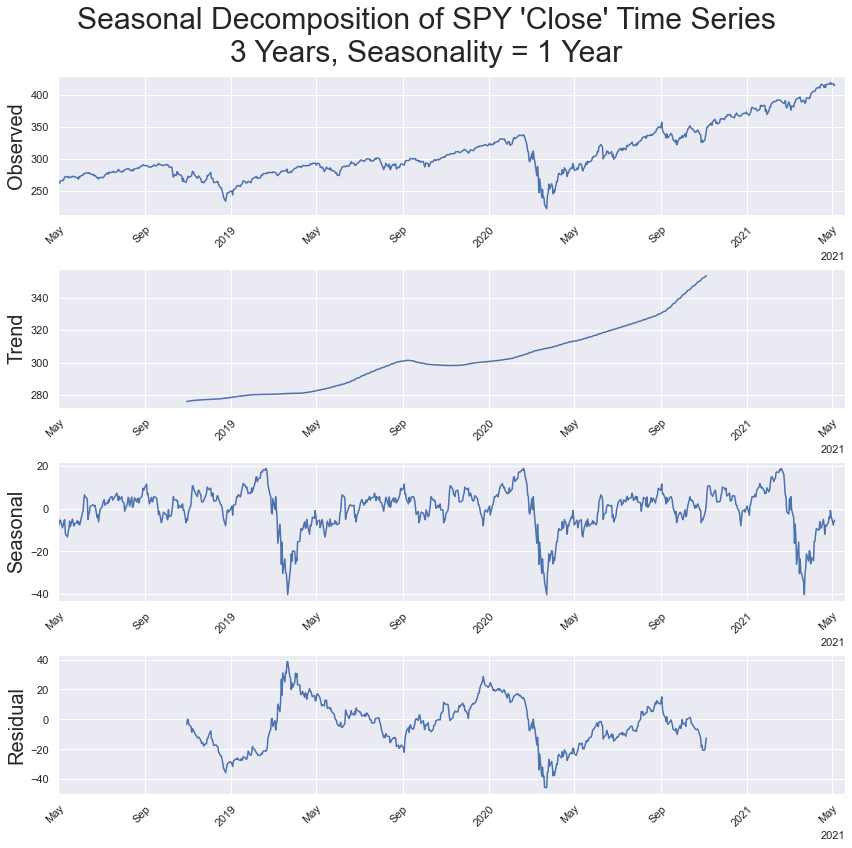

In [260]:
plot_seasonal_decomposition(df_full_3Y_close.dropna(), 'SPY \'Close\'', 3, 'years', '1 Day', 261)

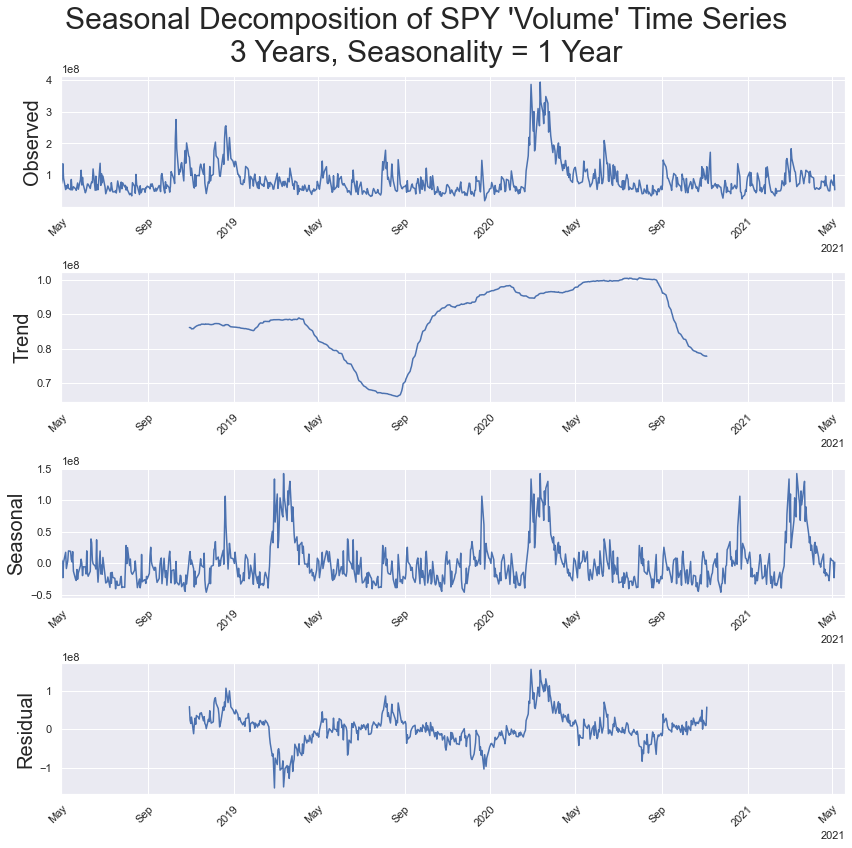

In [266]:
plot_seasonal_decomposition(df_full_3Y_vol.dropna(), 'SPY \'Volume\'', 3, 'years', '1 Day', 261)

### 5 Years, Freq = Custom Business Day, Yearly Seasonality

In [ ]:
plot_seasonal_decomposition(df_full_5Y_close.dropna(), 'SPY \'Volume\'', 5, 'years', '1 Day', 261)

### 10 Years, Freq = Custom Business Day, Yearly Seasonality

Functions loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.


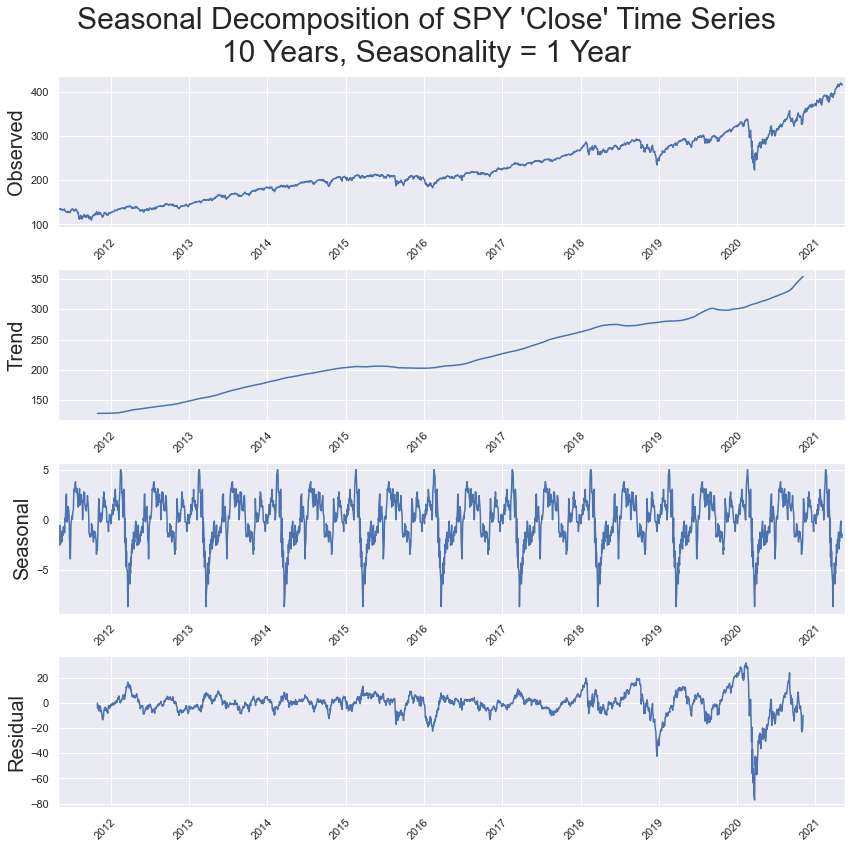

In [259]:
plot_seasonal_decomposition(df_full_10Y_close.dropna(), 'SPY \'Close\'', 10, 'years', '1 Day', 261)

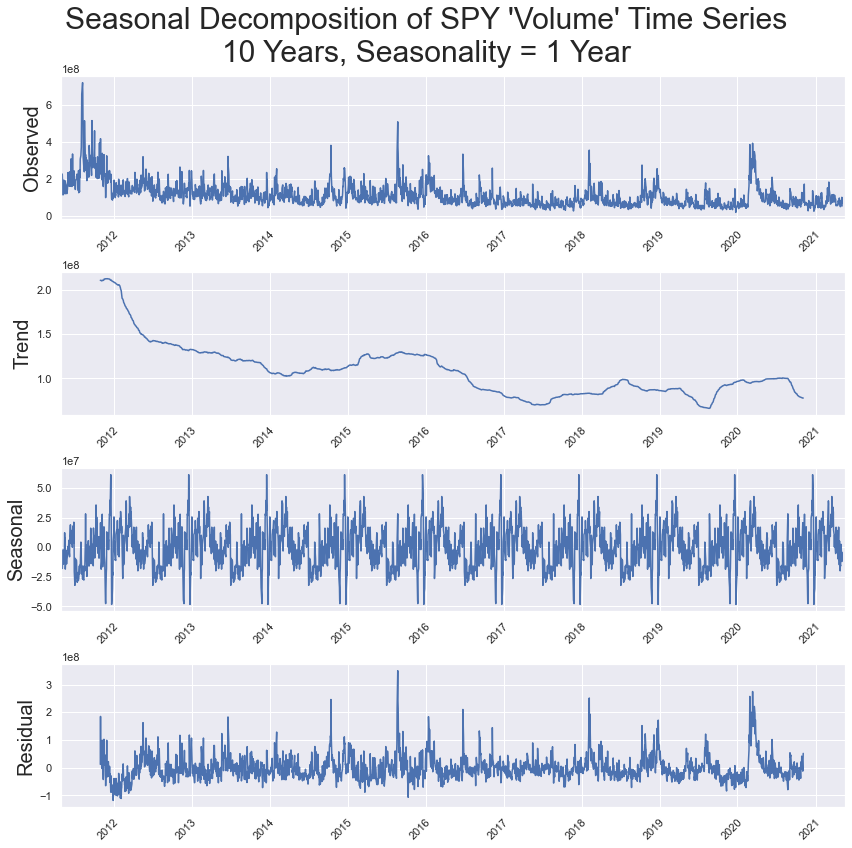

In [265]:
plot_seasonal_decomposition(df_full_10Y_vol, 'SPY \'Volume\'', 10, 'years', '1 Day', 261)

# Modeling

## Last 3 Years, 1 Day

In [147]:
index = pd.date_range(pd.Timestamp.today().date() - 119*cbd, pd.Timestamp.today().date(), freq=cbd)
a = [100*np.sin(2*np.pi*t*(440/14400)) + 10*np.random.normal() + 10*t for t in np.arange(120)]
b = [0.1*np.random.normal() - 2*t + 0.001*t**2  for t in np.arange(120)]
c = [0.3*np.random.normal() + 5*t - 0.003*t**2 for t in np.arange(120)]

In [154]:
index.name = 'date'

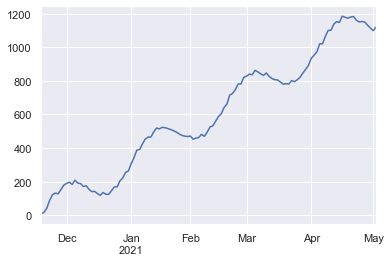

In [148]:
en = pd.Series(a, index=index, name='en')
en.plot()

In [155]:
ex = pd.DataFrame(list(zip(b, c)), index=index, columns=['b','c'])
ex

,b,c
date,,
2020-11-18,0.054400,-0.061264
2020-11-19,-1.986228,5.029789
2020-11-20,-4.167942,10.308795
2020-11-23,-6.021163,14.985104
2020-11-24,-7.928865,19.864736
...,...,...
2021-04-28,-216.850078,534.842386
2021-04-29,-218.493786,539.185952
2021-04-30,-220.226315,544.326869


In [159]:
test_mod = Pmdarima_Model(en, ex, 'Dummy En', 'Dummy Ex',
                          n=120, period='days', freq='1 Day', seas=1, fit_seas=False,
                          train_size=50, impute=False, verbose=1, estimate_diffs=False,
                          date=True, fourier=False, box=False, log=False, gridsearch=False)

Pmdarima_Model.py loaded.
Successfully created instance of Class Pmdarima_Model.


Pmdarima_Model.py loaded.
Starting AutoARIMA...
Endogenous data set diffs to use: 1
Using DateFeaturizer.
Parameters for Pipeline: 
[('date', DateFeaturizer(column_name='date')), ('arima', AutoARIMA(d=1, maxiter=200, seasonal=False, trace=3))]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=512.658, Time=0.37 sec
First viable model found (512.658)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=525.709, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=519.062, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=522.601, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=535.220, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=507.152, Time=0.43 sec
New best model found (507.152 < 512.658)
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=520.261, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=512.432, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=502.496, Time=0.37 sec
New best model found (502.496 < 507.152)
 ARIMA(0,1

ValueError: y should be a 1d array, got an array of shape (60, 2) instead.

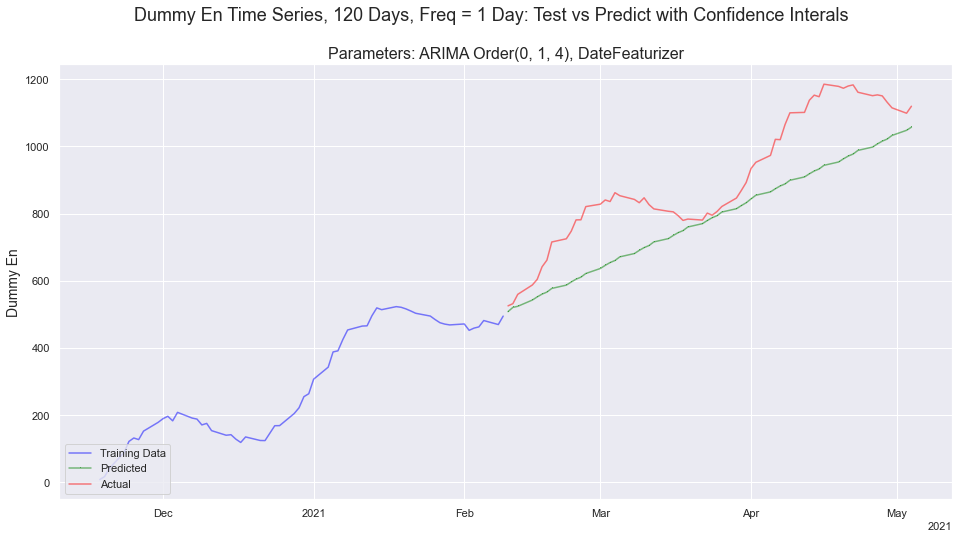

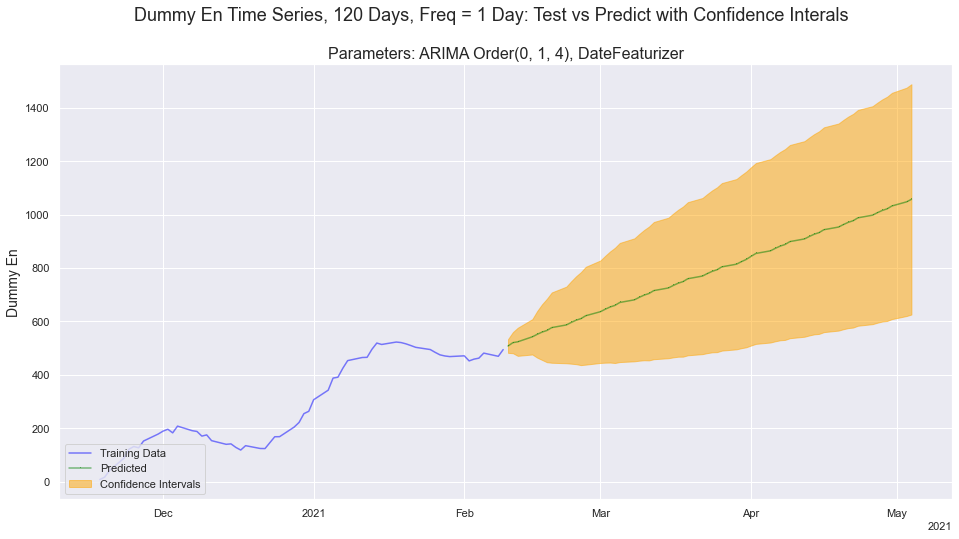

In [162]:
test_endo_pipe, test_exog_pipe = test_mod.run_auto_pipeline(en=True, ex=True, show_summary=False, visualize=True)

In [114]:
endo_train, endo_test = pm.model_selection.train_test_split(en,
            train_size = 50/100)

In [116]:
endo_test

2021-02-10   -0.759597
2021-02-11   -0.677820
2021-02-12   -0.440104
2021-02-15   -0.443424
2021-02-16   -0.249237
                ...   
2021-04-28   -0.026896
2021-04-29   -0.298134
2021-04-30   -0.488163
2021-05-03   -0.648405
2021-05-04   -0.664099
Freq: C, Name: en, Length: 60, dtype: float64

### Using Custom Class `Pmdarima_Model`

In [216]:
# pam_3Y = Pmdarima_Model_En_Ex(df_full_3Y_close, df_full_3Y_vol, 'SPY \'Close\'', 'SPY \'Volume\'',
#                n=3, period='years', freq='1 Day', seas=0, fseas=261, fit_seas=True,
#                train_size=80, impute=0, verbose=1,
#                date=1, fourier=0, box=0, log=0, gridsearch=0)

Successfully created instance of Class Pmdarima_Model.


#### Close

In [29]:
pam_3Y = Pmdarima_Model(df_full_3Y_close, 'SPY \'Close\'',
               n=3, periods='years', freq='1 Day', seas=261, f_seas=261, fit_seas=False,
               estimate_diffs=True, train_size=80, impute=False, verbose=1,
               date=True, fourier=True, box=False, log=False)

Successfully created instance of Class Pmdarima_Model.


Starting AutoARIMA...
Data set diffs to use: 1
Using DateFeaturizer.
Using FourierFeaturizer.
Parameters for Pipeline: 
[('date', DateFeaturizer(column_name='date')), ('fourier', FourierFeaturizer(k=4, m=261)), ('arima', AutoARIMA(d=1, maxiter=200, seasonal=False, trace=3))]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3520.087, Time=1.88 sec
First viable model found (3520.087)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3566.743, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3531.585, Time=2.49 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3540.395, Time=2.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3564.895, Time=0.79 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3519.765, Time=1.60 sec
New best model found (3519.765 < 3520.087)
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3518.297, Time=1.31 sec
New best model found (3518.297 < 3519.765)
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3519.373, Time=1.43 sec
 ARIMA(1,1,1)(0,0,0)[0] interc

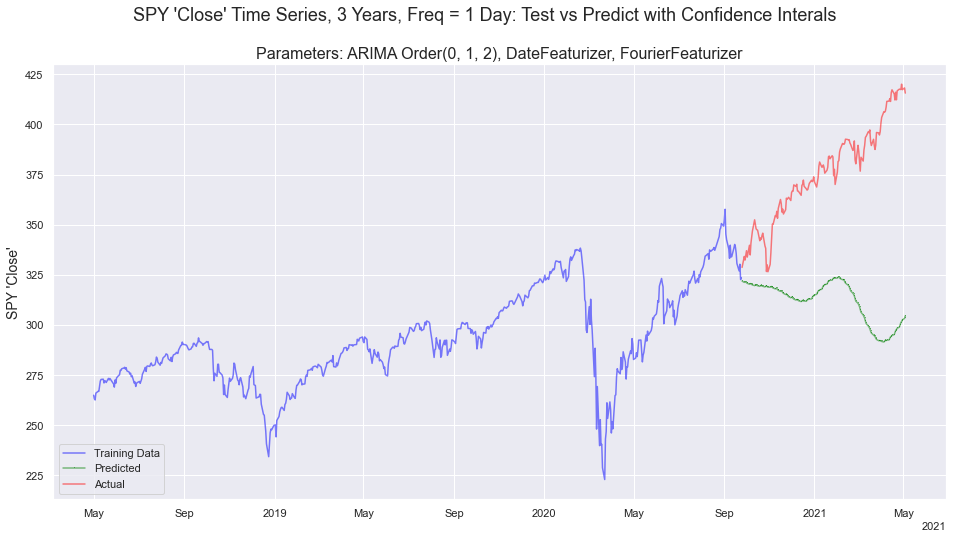

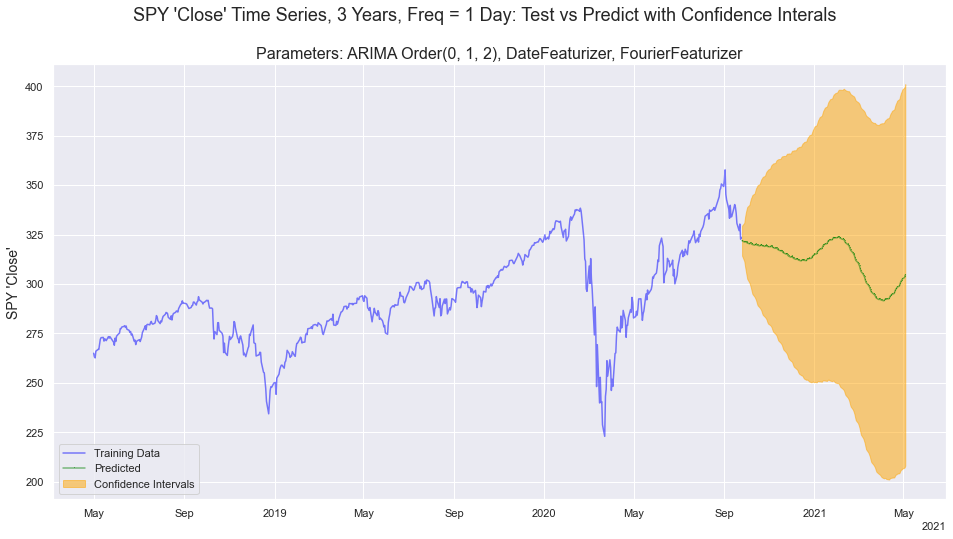

In [30]:
pam_3Y_auto_pipe = pam_3Y.run_auto_pipeline(verbose=1, visualize=True)

Starting step-wise cross-validation on best model from AutoArima...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


>_
 Done.
Test AIC: 4366.90
Test RMSE: 3.57
This is 1.22% of the avg observed value.
Test SMAPE: 0.74%



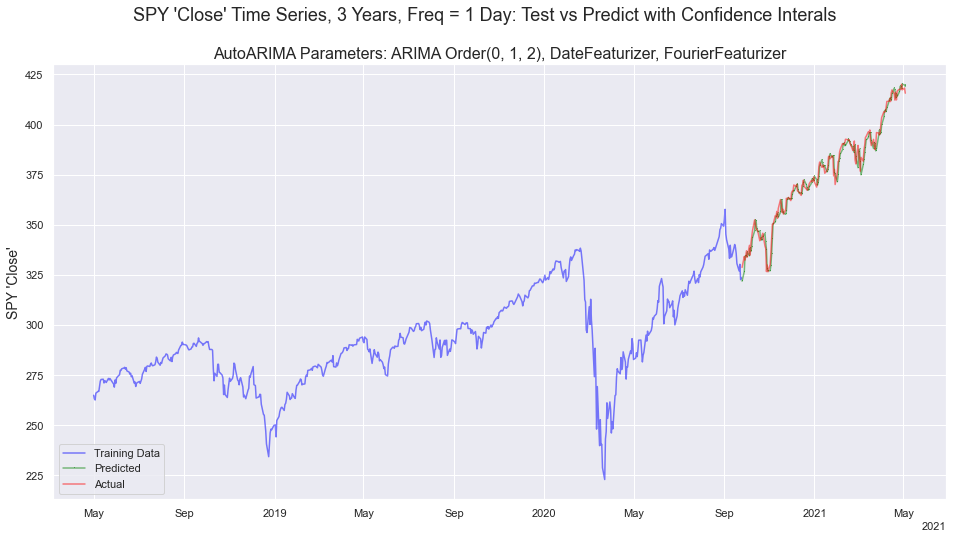

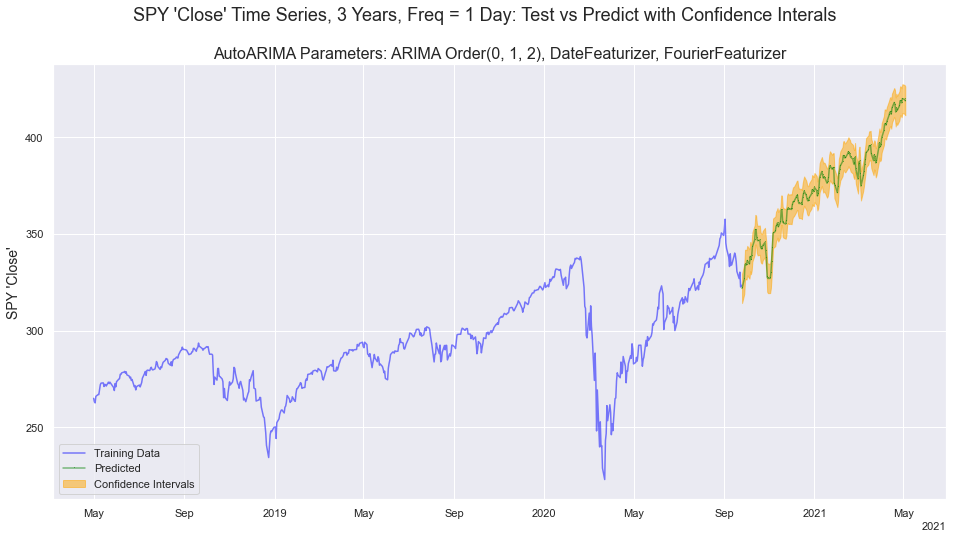

In [31]:
AIC, RMSE, SMAPE = pam_3Y.run_stepwise_cv(dynamic=False, verbose=1, visualize=True)

In [ ]:
pam_3Y_best = pam_3Y.run_gridsearch_CV(max_order=3, box=False, log=False, debug=True, parallel=False)

#### Volume

In [73]:
pam_3Y_vol = Pmdarima_Model(df_full_3Y_vol, 'SPY \'Volume\'', train_size=80,
                            n=3, periods='years', freq='1 Day', trend='c', start_order=(1, 1, 1), seas=261, f_seas=261,
                            no_intercept=False, fit_seas=False,
                            estimate_diffs=True, impute=False, verbose=1,
                            date=True, fourier=True, box=False, log=True)

Pmdarima_Model.py loaded.
Successfully created instance of Class Pmdarima_Model.


In [45]:
pam_3Y_vol_best, scores = pam_3Y_vol.run_gridsearch_CV(max_order=2,
                                                       t_list=['n','c','t','ct'],
                                                   fourier=True, box=False, log=True,
                                                   verbose=1, debug=True, parallel=False)

Pmdarima_Model.py loaded.
Starting GridSearchCV...
ARIMA Order(0, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
ARIMA Order(0, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
ARIMA Order(0, 1, 0)['n'], DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 0)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
ARIMA Order(0, 1, 0)['c'], DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 0)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
ARIMA Order(0, 1, 0)['t'], DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 0)['ct'

ARIMA Order(0, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 416.97 | RMSE: 27082379.31 | SMAPE 25.04
Model[ARIMA Order(0, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=416.974 | RMSE=27082379.310 | SMAPE=25.035
First viable model found, RMSE=27082379.310
ARIMA Order(0, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 33581.30 | RMSE: 27360754.89 | SMAPE 26.24
Model[ARIMA Order(0, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=33581.299 | RMSE=27360754.889 | SMAPE=26.244
ARIMA Order(0, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 416.97 | RMSE: 27082379.31 | SMAPE 25.04
Model[ARIMA Order(0, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=416.974 | RMSE=27082379.310 | SMAPE=25.035
ARIMA Order(0, 1, 0)['n'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['n'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 33581.30 | RMSE: 27360754.89 | SMAPE 26.24
Model[ARIMA Order(0, 1, 0)['n'], DateFeaturizer, FourierFeaturizer]: AIC=33581.299 | RMSE=27360754.889 | SMAPE=26.244
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 418.97 | RMSE: 27106333.26 | SMAPE 25.05
Model[ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=418.973 | RMSE=27106333.261 | SMAPE=25.052
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29282.26 | RMSE: 27360800.37 | SMAPE 26.24
Model[ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29282.260 | RMSE=27360800.372 | SMAPE=26.244
ARIMA Order(0, 1, 0)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 418.97 | RMSE: 27106333.26 | SMAPE 25.05
Model[ARIMA Order(0, 1, 0)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=418.973 | RMSE=27106333.261 | SMAPE=25.052
ARIMA Order(0, 1, 0)['c'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['c'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29282.26 | RMSE: 27360800.37 | SMAPE 26.24
Model[ARIMA Order(0, 1, 0)['c'], DateFeaturizer, FourierFeaturizer]: AIC=29282.260 | RMSE=27360800.372 | SMAPE=26.244
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 422.99 | RMSE: 27168611.62 | SMAPE 25.22
Model[ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=422.985 | RMSE=27168611.620 | SMAPE=25.216
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29282.26 | RMSE: 27361186.13 | SMAPE 26.25
Model[ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29282.261 | RMSE=27361186.127 | SMAPE=26.247
ARIMA Order(0, 1, 0)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 422.99 | RMSE: 27168611.62 | SMAPE 25.22
Model[ARIMA Order(0, 1, 0)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=422.985 | RMSE=27168611.620 | SMAPE=25.216
ARIMA Order(0, 1, 0)['t'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['t'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29282.26 | RMSE: 27361186.13 | SMAPE 26.25
Model[ARIMA Order(0, 1, 0)['t'], DateFeaturizer, FourierFeaturizer]: AIC=29282.261 | RMSE=27361186.127 | SMAPE=26.247
ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 423.20 | RMSE: 27115570.90 | SMAPE 25.16
Model[ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=423.198 | RMSE=27115570.898 | SMAPE=25.163
ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29284.26 | RMSE: 27361682.26 | SMAPE 26.25
Model[ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29284.264 | RMSE=27361682.262 | SMAPE=26.251
ARIMA Order(0, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 423.20 | RMSE: 27115570.90 | SMAPE 25.16
Model[ARIMA Order(0, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=423.198 | RMSE=27115570.898 | SMAPE=25.163
ARIMA Order(0, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29284.26 | RMSE: 27361682.26 | SMAPE 26.25
Model[ARIMA Order(0, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer]: AIC=29284.264 | RMSE=27361682.262 | SMAPE=26.251
ARIMA Order(0, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 290.34 | RMSE: 24157503.68 | SMAPE 23.73
Model[ARIMA Order(0, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=290.345 | RMSE=24157503.678 | SMAPE=23.733
Next best model found, RMSE=24157503.678
ARIMA Order(0, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29178.35 | RMSE: 24886741.51 | SMAPE 25.32
Model[ARIMA Order(0, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29178.349 | RMSE=24886741.513 | SMAPE=25.319
ARIMA Order(0, 1, 1)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 290.34 | RMSE: 24157503.68 | SMAPE 23.73
Model[ARIMA Order(0, 1, 1)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=290.345 | RMSE=24157503.678 | SMAPE=23.733
ARIMA Order(0, 1, 1)['n'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['n'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29178.35 | RMSE: 24886741.51 | SMAPE 25.32
Model[ARIMA Order(0, 1, 1)['n'], DateFeaturizer, FourierFeaturizer]: AIC=29178.349 | RMSE=24886741.513 | SMAPE=25.319
ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 292.34 | RMSE: 24161128.83 | SMAPE 23.73
Model[ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=292.344 | RMSE=24161128.833 | SMAPE=23.725
ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29180.39 | RMSE: 24887979.13 | SMAPE 25.31
Model[ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29180.385 | RMSE=24887979.130 | SMAPE=25.309
ARIMA Order(0, 1, 1)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 292.34 | RMSE: 24161128.83 | SMAPE 23.73
Model[ARIMA Order(0, 1, 1)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=292.344 | RMSE=24161128.833 | SMAPE=23.725
ARIMA Order(0, 1, 1)['c'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['c'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29180.39 | RMSE: 24887979.13 | SMAPE 25.31
Model[ARIMA Order(0, 1, 1)['c'], DateFeaturizer, FourierFeaturizer]: AIC=29180.385 | RMSE=24887979.130 | SMAPE=25.309
ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 299.67 | RMSE: 24194774.07 | SMAPE 23.49
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=299.670 | RMSE=24194774.067 | SMAPE=23.487
ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29180.38 | RMSE: 24889667.99 | SMAPE 25.30
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29180.377 | RMSE=24889667.987 | SMAPE=25.304
ARIMA Order(0, 1, 1)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 299.67 | RMSE: 24194774.07 | SMAPE 23.49
Model[ARIMA Order(0, 1, 1)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=299.670 | RMSE=24194774.067 | SMAPE=23.487
ARIMA Order(0, 1, 1)['t'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['t'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29180.38 | RMSE: 24889667.99 | SMAPE 25.30
Model[ARIMA Order(0, 1, 1)['t'], DateFeaturizer, FourierFeaturizer]: AIC=29180.377 | RMSE=24889667.987 | SMAPE=25.304
ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 301.70 | RMSE: 24189725.87 | SMAPE 23.48
Model[ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=301.697 | RMSE=24189725.867 | SMAPE=23.478
ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29182.39 | RMSE: 24888338.84 | SMAPE 25.31
Model[ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29182.385 | RMSE=24888338.842 | SMAPE=25.307
ARIMA Order(0, 1, 1)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 301.70 | RMSE: 24189725.87 | SMAPE 23.48
Model[ARIMA Order(0, 1, 1)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=301.697 | RMSE=24189725.867 | SMAPE=23.478
ARIMA Order(0, 1, 1)['ct'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['ct'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29182.39 | RMSE: 24888338.84 | SMAPE 25.31
Model[ARIMA Order(0, 1, 1)['ct'], DateFeaturizer, FourierFeaturizer]: AIC=29182.385 | RMSE=24888338.842 | SMAPE=25.307
ARIMA Order(0, 1, 2)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 278.37 | RMSE: 24124558.39 | SMAPE 23.38
Model[ARIMA Order(0, 1, 2)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=278.373 | RMSE=24124558.390 | SMAPE=23.382
Next best model found, RMSE=24124558.390
ARIMA Order(0, 1, 2)['n'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['n'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29170.34 | RMSE: 24785841.20 | SMAPE 25.11
Model[ARIMA Order(0, 1, 2)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29170.339 | RMSE=24785841.197 | SMAPE=25.113
ARIMA Order(0, 1, 2)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 278.37 | RMSE: 24124558.39 | SMAPE 23.38
Model[ARIMA Order(0, 1, 2)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=278.373 | RMSE=24124558.390 | SMAPE=23.382
ARIMA Order(0, 1, 2)['n'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['n'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29170.34 | RMSE: 24785841.20 | SMAPE 25.11
Model[ARIMA Order(0, 1, 2)['n'], DateFeaturizer, FourierFeaturizer]: AIC=29170.339 | RMSE=24785841.197 | SMAPE=25.113
ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 280.38 | RMSE: 24124511.28 | SMAPE 23.37
Model[ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=280.382 | RMSE=24124511.275 | SMAPE=23.367
Next best model found, RMSE=24124511.275
ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29172.34 | RMSE: 24785991.87 | SMAPE 25.11
Model[ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29172.345 | RMSE=24785991.870 | SMAPE=25.109
ARIMA Order(0, 1, 2)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 280.38 | RMSE: 24124511.28 | SMAPE 23.37
Model[ARIMA Order(0, 1, 2)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=280.382 | RMSE=24124511.275 | SMAPE=23.367
ARIMA Order(0, 1, 2)['c'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['c'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29172.34 | RMSE: 24785991.87 | SMAPE 25.11
Model[ARIMA Order(0, 1, 2)['c'], DateFeaturizer, FourierFeaturizer]: AIC=29172.345 | RMSE=24785991.870 | SMAPE=25.109
ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 287.30 | RMSE: 24074918.45 | SMAPE 23.44
Model[ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=287.296 | RMSE=24074918.449 | SMAPE=23.439
Next best model found, RMSE=24074918.449
ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29172.38 | RMSE: 24789176.85 | SMAPE 25.09
Model[ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29172.375 | RMSE=24789176.853 | SMAPE=25.094
ARIMA Order(0, 1, 2)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 287.30 | RMSE: 24074918.45 | SMAPE 23.44
Model[ARIMA Order(0, 1, 2)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=287.296 | RMSE=24074918.449 | SMAPE=23.439
ARIMA Order(0, 1, 2)['t'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['t'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29172.38 | RMSE: 24789176.85 | SMAPE 25.09
Model[ARIMA Order(0, 1, 2)['t'], DateFeaturizer, FourierFeaturizer]: AIC=29172.375 | RMSE=24789176.853 | SMAPE=25.094
ARIMA Order(0, 1, 2)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 289.27 | RMSE: 24099625.32 | SMAPE 23.48
Model[ARIMA Order(0, 1, 2)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=289.268 | RMSE=24099625.319 | SMAPE=23.483
ARIMA Order(0, 1, 2)['ct'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['ct'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29174.41 | RMSE: 24795751.42 | SMAPE 25.08
Model[ARIMA Order(0, 1, 2)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29174.414 | RMSE=24795751.421 | SMAPE=25.084
ARIMA Order(0, 1, 2)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 289.27 | RMSE: 24099625.32 | SMAPE 23.48
Model[ARIMA Order(0, 1, 2)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=289.268 | RMSE=24099625.319 | SMAPE=23.483
ARIMA Order(0, 1, 2)['ct'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['ct'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29174.41 | RMSE: 24795751.42 | SMAPE 25.08
Model[ARIMA Order(0, 1, 2)['ct'], DateFeaturizer, FourierFeaturizer]: AIC=29174.414 | RMSE=24795751.421 | SMAPE=25.084
ARIMA Order(1, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 329.83 | RMSE: 24841200.61 | SMAPE 23.39
Model[ARIMA Order(1, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=329.832 | RMSE=24841200.615 | SMAPE=23.390
ARIMA Order(1, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29206.17 | RMSE: 25555022.13 | SMAPE 25.17
Model[ARIMA Order(1, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29206.169 | RMSE=25555022.133 | SMAPE=25.171
ARIMA Order(1, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 329.83 | RMSE: 24841200.61 | SMAPE 23.39
Model[ARIMA Order(1, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=329.832 | RMSE=24841200.615 | SMAPE=23.390
ARIMA Order(1, 1, 0)['n'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['n'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29206.17 | RMSE: 25555022.13 | SMAPE 25.17
Model[ARIMA Order(1, 1, 0)['n'], DateFeaturizer, FourierFeaturizer]: AIC=29206.169 | RMSE=25555022.133 | SMAPE=25.171
ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 331.83 | RMSE: 24854520.92 | SMAPE 23.40
Model[ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=331.828 | RMSE=24854520.920 | SMAPE=23.401
ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29208.17 | RMSE: 25555250.37 | SMAPE 25.17
Model[ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29208.174 | RMSE=25555250.372 | SMAPE=25.165
ARIMA Order(1, 1, 0)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 331.83 | RMSE: 24854520.92 | SMAPE 23.40
Model[ARIMA Order(1, 1, 0)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=331.828 | RMSE=24854520.920 | SMAPE=23.401
ARIMA Order(1, 1, 0)['c'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['c'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29208.17 | RMSE: 25555250.37 | SMAPE 25.17
Model[ARIMA Order(1, 1, 0)['c'], DateFeaturizer, FourierFeaturizer]: AIC=29208.174 | RMSE=25555250.372 | SMAPE=25.165
ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 333.66 | RMSE: 24778282.78 | SMAPE 23.41
Model[ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=333.660 | RMSE=24778282.784 | SMAPE=23.409
ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29208.18 | RMSE: 25556054.69 | SMAPE 25.16
Model[ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29208.176 | RMSE=25556054.690 | SMAPE=25.158
ARIMA Order(1, 1, 0)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 333.66 | RMSE: 24778282.78 | SMAPE 23.41
Model[ARIMA Order(1, 1, 0)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=333.660 | RMSE=24778282.784 | SMAPE=23.409
ARIMA Order(1, 1, 0)['t'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['t'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29208.18 | RMSE: 25556054.69 | SMAPE 25.16
Model[ARIMA Order(1, 1, 0)['t'], DateFeaturizer, FourierFeaturizer]: AIC=29208.176 | RMSE=25556054.690 | SMAPE=25.158
ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 335.93 | RMSE: 24793505.84 | SMAPE 23.45
Model[ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=335.934 | RMSE=24793505.841 | SMAPE=23.447
ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29210.17 | RMSE: 25556431.84 | SMAPE 25.16
Model[ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29210.175 | RMSE=25556431.840 | SMAPE=25.155
ARIMA Order(1, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 335.93 | RMSE: 24793505.84 | SMAPE 23.45
Model[ARIMA Order(1, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=335.934 | RMSE=24793505.841 | SMAPE=23.447
ARIMA Order(1, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29210.17 | RMSE: 25556431.84 | SMAPE 25.16
Model[ARIMA Order(1, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer]: AIC=29210.175 | RMSE=25556431.840 | SMAPE=25.155
ARIMA Order(1, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 267.73 | RMSE: 23994484.45 | SMAPE 22.88
Model[ARIMA Order(1, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=267.729 | RMSE=23994484.446 | SMAPE=22.879
Next best model found, RMSE=23994484.446
ARIMA Order(1, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29163.43 | RMSE: 24705623.64 | SMAPE 24.70
Model[ARIMA Order(1, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29163.428 | RMSE=24705623.637 | SMAPE=24.700
ARIMA Order(1, 1, 1)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 267.73 | RMSE: 23994484.45 | SMAPE 22.88
Model[ARIMA Order(1, 1, 1)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=267.729 | RMSE=23994484.446 | SMAPE=22.879
ARIMA Order(1, 1, 1)['n'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['n'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29163.43 | RMSE: 24705623.64 | SMAPE 24.70
Model[ARIMA Order(1, 1, 1)['n'], DateFeaturizer, FourierFeaturizer]: AIC=29163.428 | RMSE=24705623.637 | SMAPE=24.700
ARIMA Order(1, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 269.88 | RMSE: 23971769.85 | SMAPE 22.83
Model[ARIMA Order(1, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=269.885 | RMSE=23971769.850 | SMAPE=22.826
Next best model found, RMSE=23971769.850
ARIMA Order(1, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29165.59 | RMSE: 24708472.45 | SMAPE 24.66
Model[ARIMA Order(1, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29165.592 | RMSE=24708472.449 | SMAPE=24.656
ARIMA Order(1, 1, 1)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 269.88 | RMSE: 23971769.85 | SMAPE 22.83
Model[ARIMA Order(1, 1, 1)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=269.885 | RMSE=23971769.850 | SMAPE=22.826
ARIMA Order(1, 1, 1)['c'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['c'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29165.59 | RMSE: 24708472.45 | SMAPE 24.66
Model[ARIMA Order(1, 1, 1)['c'], DateFeaturizer, FourierFeaturizer]: AIC=29165.592 | RMSE=24708472.449 | SMAPE=24.656
ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 284.68 | RMSE: 24063307.00 | SMAPE 23.32
Model[ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=284.682 | RMSE=24063307.000 | SMAPE=23.321
ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29165.57 | RMSE: 24715963.90 | SMAPE 24.62
Model[ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29165.574 | RMSE=24715963.902 | SMAPE=24.623
ARIMA Order(1, 1, 1)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 284.68 | RMSE: 24063307.00 | SMAPE 23.32
Model[ARIMA Order(1, 1, 1)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=284.682 | RMSE=24063307.000 | SMAPE=23.321
ARIMA Order(1, 1, 1)['t'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['t'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29165.57 | RMSE: 24715963.90 | SMAPE 24.62
Model[ARIMA Order(1, 1, 1)['t'], DateFeaturizer, FourierFeaturizer]: AIC=29165.574 | RMSE=24715963.902 | SMAPE=24.623
ARIMA Order(1, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 286.77 | RMSE: 24058126.59 | SMAPE 23.29
Model[ARIMA Order(1, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=286.774 | RMSE=24058126.587 | SMAPE=23.295
ARIMA Order(1, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29167.59 | RMSE: 24709921.92 | SMAPE 24.65
Model[ARIMA Order(1, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29167.594 | RMSE=24709921.925 | SMAPE=24.649
ARIMA Order(1, 1, 1)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 286.77 | RMSE: 24058126.59 | SMAPE 23.29
Model[ARIMA Order(1, 1, 1)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=286.774 | RMSE=24058126.587 | SMAPE=23.295
ARIMA Order(1, 1, 1)['ct'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['ct'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29167.59 | RMSE: 24709921.92 | SMAPE 24.65
Model[ARIMA Order(1, 1, 1)['ct'], DateFeaturizer, FourierFeaturizer]: AIC=29167.594 | RMSE=24709921.925 | SMAPE=24.649
ARIMA Order(2, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 306.82 | RMSE: 24457608.35 | SMAPE 23.55
Model[ARIMA Order(2, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=306.815 | RMSE=24457608.355 | SMAPE=23.550
ARIMA Order(2, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29188.55 | RMSE: 25186203.12 | SMAPE 25.28
Model[ARIMA Order(2, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29188.548 | RMSE=25186203.118 | SMAPE=25.285
ARIMA Order(2, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 306.82 | RMSE: 24457608.35 | SMAPE 23.55
Model[ARIMA Order(2, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=306.815 | RMSE=24457608.355 | SMAPE=23.550
ARIMA Order(2, 1, 0)['n'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['n'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29188.55 | RMSE: 25186203.12 | SMAPE 25.28
Model[ARIMA Order(2, 1, 0)['n'], DateFeaturizer, FourierFeaturizer]: AIC=29188.548 | RMSE=25186203.118 | SMAPE=25.285
ARIMA Order(2, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 308.81 | RMSE: 24470921.75 | SMAPE 23.57
Model[ARIMA Order(2, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=308.815 | RMSE=24470921.751 | SMAPE=23.566
ARIMA Order(2, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29190.58 | RMSE: 25187021.10 | SMAPE 25.27
Model[ARIMA Order(2, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29190.576 | RMSE=25187021.095 | SMAPE=25.269
ARIMA Order(2, 1, 0)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 308.81 | RMSE: 24470921.75 | SMAPE 23.57
Model[ARIMA Order(2, 1, 0)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=308.815 | RMSE=24470921.751 | SMAPE=23.566
ARIMA Order(2, 1, 0)['c'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['c'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29190.58 | RMSE: 25187021.10 | SMAPE 25.27
Model[ARIMA Order(2, 1, 0)['c'], DateFeaturizer, FourierFeaturizer]: AIC=29190.576 | RMSE=25187021.095 | SMAPE=25.269
ARIMA Order(2, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 311.42 | RMSE: 24430526.96 | SMAPE 23.66
Model[ARIMA Order(2, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=311.423 | RMSE=24430526.957 | SMAPE=23.657
ARIMA Order(2, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29190.56 | RMSE: 25187267.49 | SMAPE 25.27
Model[ARIMA Order(2, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29190.556 | RMSE=25187267.490 | SMAPE=25.269
ARIMA Order(2, 1, 0)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 311.42 | RMSE: 24430526.96 | SMAPE 23.66
Model[ARIMA Order(2, 1, 0)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=311.423 | RMSE=24430526.957 | SMAPE=23.657
ARIMA Order(2, 1, 0)['t'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['t'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29190.56 | RMSE: 25187267.49 | SMAPE 25.27
Model[ARIMA Order(2, 1, 0)['t'], DateFeaturizer, FourierFeaturizer]: AIC=29190.556 | RMSE=25187267.490 | SMAPE=25.269
ARIMA Order(2, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 311.61 | RMSE: 24454074.11 | SMAPE 23.62
Model[ARIMA Order(2, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=311.613 | RMSE=24454074.105 | SMAPE=23.623
ARIMA Order(2, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29192.59 | RMSE: 25185888.67 | SMAPE 25.29
Model[ARIMA Order(2, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29192.591 | RMSE=25185888.672 | SMAPE=25.289
ARIMA Order(2, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 311.61 | RMSE: 24454074.11 | SMAPE 23.62
Model[ARIMA Order(2, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=311.613 | RMSE=24454074.105 | SMAPE=23.623
ARIMA Order(2, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29192.59 | RMSE: 25185888.67 | SMAPE 25.29
Model[ARIMA Order(2, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer]: AIC=29192.591 | RMSE=25185888.672 | SMAPE=25.289

GridsearchCV Completed.

Top 10 models:
Model[ARIMA Order(1, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=269.885 | RMSE=23971769.850 | SMAPE=22.826
Model[ARIMA Order(1, 1, 1)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=269.885 | RMSE=23971769.850 | SMAPE=22.826
Model[ARIMA Order(1, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=267.729 | RMSE=23994484.446 | SMAPE=22.879
Model[ARIMA Order(1, 1, 1)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=267.729 | RMSE=23994484.446 | SMAPE=22.879
Model[ARIMA Order(1, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=286.774 | RMSE=24058126.587 | SMAPE=23.295
Model[ARIMA Order(1, 1, 1)['ct'], DateFeaturizer, FourierFeaturi

Pmdarima_Model.py loaded.
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='c'))])
Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
Test AIC: 576.39
Test RMSE: 23724220.02
This is 26.96% of the avg observed value.
Test SMAPE: 22.21%



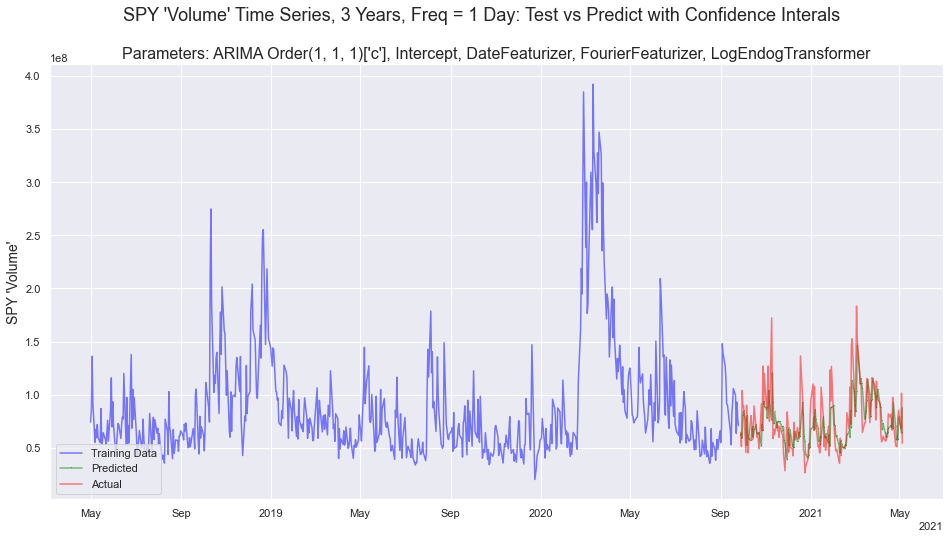

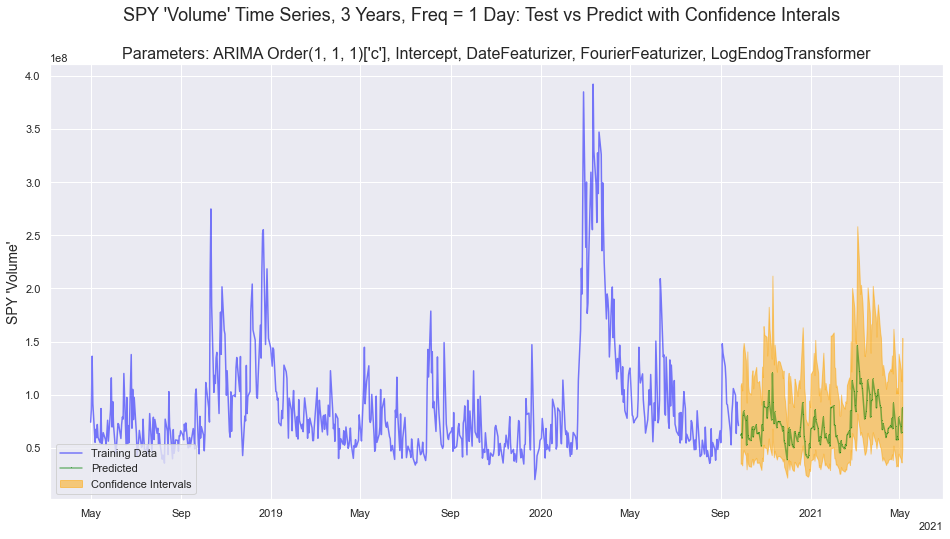

In [76]:
AIC, RMSE, SMAPE = pam_3Y_vol.run_stepwise_CV(pam_3Y_vol_best, dynamic=False, verbose=1, visualize=True)

In [71]:
pam_3Y_best.fit(df_full_10Y_close, vol_10Y_df)

Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='t'))])

In [ ]:
pam_3Y_best.fit(df_full_10Y_close, vol_10Y_df)

In [ ]:
pam_3Y.run_stepwise_cv(en=True, ex=False, dynamic=True, visualize=True)
Audio(sound_file, autoplay=True)

In [549]:
arima_params = dict(
                trace=3,
                maxiter=200,
                stepwise=True,
                seasonal=False,
                suppress_warnings=True)

order = None
models = []
for d in range(1):
    mod_order = 0
    for p in range(6):
        for q in range(6):
            mod_order = p+q
            if mod_order > 3:
                continue
            # order = f'({p}, {d}, {q})'
            order = [p, d, q]
            print(f'Order = {str(tuple(order))}')
            params = []
            params.append(('date', date_feat))
            params.append(('fourier', pm.preprocessing.FourierFeaturizer(m=261, k=4)))
            for feats in range(4):
                if feats == 0:
                    pass
                elif feats == 1:
                    params.append(('box', pm.preprocessing.BoxCoxdfgTransformer()))
                elif feats == 2:
                    params.append(('box', pm.preprocessing.BoxCoxdfgTransformer()))
                elif feats == 3:
                    params.append(('box', pm.preprocessing.BoxCoxdfgTransformer()))
                    params.append(('log', pm.preprocessing.LogdfgTransformer()))
                params.append(('arima', pm.arima.ARIMA(**arima_params)))
                models.append(order, params)

Order = (0, 0, 0)


TypeError: __init__() missing 1 required positional argument: 'order'

### Forecasting into the future

In [167]:
# today = datetime.date.today()
today = pd.Timestamp.today()
today

new_dates = pd.date_range(start=today, periods=5, freq=cbd)
new_dates

# index_fc = range(pam_3Y.length,pam_3Y.length+5)
index_fc = range(pam_10Y.length,pam_10Y.length+5)
# index_fc = range(df_full_10Y_close.size,df_full_10Y_close.size+5)
index_fc

new_dates_df = pd.DataFrame(new_dates, index=index_fc, columns=['date'])
new_dates_df

Timestamp('2021-05-04 15:39:29.608515')

#### Closing Prices Only

In [ ]:
pam_3Y_close = endo_pipe

In [517]:
close_hat, close_conf_ints = pam_3Y_close.predict(X=new_dates_df, return_conf_int=True)
close_hat

NameError: name 'pam_3Y_close' is not defined

#### Volume --> Close

In [ ]:
pam_3Y_vol = exog_pipe

In [ ]:
vol_hat, vol_conf_ints = pam_3Y_vol.predict(X=new_dates_df, return_conf_int=True)
vol_hat

In [ ]:
vol_hat_df = pd.DataFrame(vol_hat, index=index_fc, columns=['volume'])
vol_hat_df = vol_hat_df.join(new_dates_df)
vol_hat_df

In [621]:
len(y_train)

2089

In [55]:
date_feat = pm.preprocessing.DateFeaturizer(
    column_name="date",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)
_, X_train_feats = date_feat.fit_transform(y_train, X_train)
full_3Y_pipe = pipeline.Pipeline([
    ('date', date_feat),
    ("fourier", pm.preprocessing.FourierFeaturizer(m=261, k=4)),
    ('arima', pm.arima.AutoARIMA(d=1,
                                 trace=3,
                                 stepwise=True,
                                 suppress_warnings=True,
                                 seasonal=False))
])

In [59]:
full_3Y_pipe.fit(y_train, X_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3520.087, Time=1.82 sec
First viable model found (3520.087)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3566.743, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3531.585, Time=1.44 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3540.395, Time=1.66 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3564.895, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3519.765, Time=1.03 sec
New best model found (3519.765 < 3520.087)
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3518.297, Time=0.77 sec
New best model found (3518.297 < 3519.765)
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3519.373, Time=1.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3528.397, Time=0.71 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3519.553, Time=2.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3516.446, Time=0.85 sec
New best model found (3516.446 < 3518.297)
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3538.644, Time=0.58 sec


Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima', AutoARIMA(d=1, seasonal=False, trace=3))])

In [ ]:
full_3Y_pipe.named_steps['arima'].model_

### Test out baseArima

In [41]:
date_feat = pm.preprocessing.DateFeaturizer(
    column_name="date",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)
_, X_train_feats = date_feat.fit_transform(y_train, X_train)
arima_params = dict(
    # d = self.n_diffs,
    trace=3,
    maxiter=200,
    # stepwise=True,
    # seasonal=False,
    suppress_warnings=True)
arima_params['order'] = (0, 1, 2)
arima_params['trend'] = 'n'
pipe_params = []
pipe_params.append(('date', date_feat))
pipe_params.append(
    ('fourier', pm.preprocessing.FourierFeaturizer(m=261, k=4)))
pipe_params.append(('arima', pm.arima.ARIMA(**arima_params)))
new_3y_pipe = pipeline.Pipeline(pipe_params)

In [43]:
new_3y_pipe.fit(y_train, X_train)

Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='n'))])

In [ ]:
vol_3Y_df = pd.DataFrame(df_full_3Y_vol).reset_index()

In [ ]:
full_3Y_pipe.fit(df_full_3Y_close, vol_3Y_df)

In [602]:
close_vol_hat, close_vol_conf_ints = full_3Y_pipe.predict(X=vol_hat_df, return_conf_int=True)
close_vol_hat

NotFittedError: Model has not been fit!

#### Plot

In [ ]:
import mplfinance as mpl
import matplotlib.dates as mdates

In [153]:
close_vol_hat

Pmdarima_Model.py loaded.


NameError: name 'close_vol_hat' is not defined

In [ ]:
new_dates_df.date.values

In [ ]:
new_fc_df = pd.DataFrame(zip(new_dates_df.date.values,close_vol_hat), columns=['date','close'])
new_fc_df.set_index('date', inplace=True)

In [ ]:
new_fc_df

In [ ]:
spy_df_3Y_fc = spy_df_3Y.append(new_fc_df)

In [ ]:
class CustomFormatter(FuncFormatter):
    def __init__(self, dates, fmt='%Y-%m-%d'):
        self.dates = dates
        self.fmt = fmt

    def __call__(self, x, pos=0):
        'Return the label for time x at position pos'
        ind = int(np.round(x))
        if ind >= len(self.dates) or ind < 0:
            return ''

        return mdates.num2date(self.dates[ind]).strftime(self.fmt)

In [ ]:
# days = mdates.DayLocator()
# days_fmt = mdates.DateFormatter('%Y-%B-%d')

In [ ]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(24, 16))
# fig = mpl.figure()
mpl.plot(spy_df_3Y[-120:],
         type='candle',
#          ylabel='Closing Price (USD)',
         style="yahoo",
#          volume=True,
#          figscale=2,
         ax=ax,
#          title='Using ARIMA(3,1,2), FourierFeaturizer'
         )
ax.plot(range(120,125), close_vol_hat, 'g.', markersize=10, alpha=0.7, label='Forecast')
conf_int = np.asarray(close_vol_conf_ints)
ax.fill_between(range(120,125),
         conf_int[:, 0], conf_int[:, 1],
         alpha=0.3, color='orange',
         label="Confidence Intervals")
ax.set_xlim(0, 130)
ax.set_ylabel('Closing Price (USD)', size=16)
ax.set_title('Using ARIMA(3,1,2), FourierFeaturizer', size=18)
# xfmt = mdates.DateFormatter('%Y-%M-%d')
# ax.xaxis.set_major_formatter(xfmt)
# ax.xaxis.set_major_locator(days)
# ax.xaxis.set_major_formatter(days_fmt)
# ax.set_xticklabels(dates_dt)
# formatter = CustomFormatter(spy_df_3Y_fc)
# ax.xaxis.set_major_formatter(formatter)

# ax.xaxis.set_major_formatter(format_date)
# fig.autofmt_xdate()
# ax.xaxis_date()
# fig.tight_layout()
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
fig.subplots_adjust(top=0.92)
ax.legend(loc='upper left', borderaxespad=0.5, fontsize = 18)
fig.suptitle(f'{ylabel} Time Series, 3 Years, Freq = 1 Day: Historical vs Forecast with Confidence Interals\n', size=24)

In [ ]:
spy_df_3Y_fc.index.date

In [ ]:
labels = []
for i in label:
    labels.append(i)
labels


In [ ]:
dates = [20201116,20201214,20210111,20210208,20210308,20210405,20210503]
dates = [datetime.datetime.strptime(str(int(date)),'%Y%m%d') for date in dates]

In [ ]:
dates_dt = pd.to_datetime(dates)
dates_dt

In [ ]:
fig, ax = plt.subplots(figsize=(24, 16))
ax.plot(df_full_3Y_close[-120:], 'b.', markersize=10, alpha=0.7, label='Historical')
ax.plot(new_dates_df.date, close_vol_hat, 'g.', markersize=10, alpha=0.7, label='Forecast')
ax.set_xlim(df_full_3Y_close[-120:-119].index,new_dates_df.date[-1:]+5*cbd)
conf_int = np.asarray(close_vol_conf_ints)
ax.fill_between(new_dates_df.date,
         conf_int[:, 0], conf_int[:, 1],
         alpha=0.5, color='orange',
         label="Confidence Intervals")
ax.legend(loc='upper left', borderaxespad=0.5, fontsize = 16)
fig.suptitle(f'{ylabel} Time Series, 3 Years, Freq = 1 Day: Historical vs Forecast with Confidence Interals\n', size=24)
ax.set_ylabel(ylabel, size=16)

### Cross-Validation

In [3]:
# cv = pm.model_selection.RollingForecastCV()
cv = pm.model_selection.SlidingWindowForecastCV(window_size=100,step=1)

NameError: name 'pm' is not defined

In [ ]:
df_test

In [ ]:
cv_gen = cv.split(df_train)

In [ ]:
next(cv_gen)

In [ ]:
best_arima_2 = best_arima.to_dict()

In [ ]:
best_arima.order

#### Sliding Window

In [ ]:
est = pm.ARIMA(order = best_arima.order, intercept=False)
cv = pm.model_selection.SlidingWindowForecastCV(window_size=200, step=1, h=100)
predictions = pm.model_selection.cross_val_predict(
    est, df_full_3Y_close, cv=cv, verbose=1, averaging="median")

In [ ]:
plt.plot(df_full_3Y_close.index, df_full_3Y_close.values, alpha=0.75, c='b')
plt.plot(df_full_3Y_close.index[-predictions.size:], predictions, alpha=0.75, c='g')  # Forecasts
plt.title("Sliding Window Cross-Validated")
plt.show()

#### Rolling

In [ ]:
half_index = round(df_full_3Y_close.size/2)

In [ ]:
pipe

In [ ]:
est = pm.ARIMA(order = best_arima.order, intercept=False)
# est = pipe
# cannot use pipeline
cv = pm.model_selection.RollingForecastCV(initial=half_index)
# cannot return conf_int, even with return_conf_int=True
predictions = pm.model_selection.cross_val_predict(
    est, df_full_3Y_close.interpolate(), cv=cv, verbose=1, averaging="median")


In [ ]:
plt.plot(df_full_3Y_close.index, df_full_3Y_close.values, alpha=0.75, c='b')
plt.plot(df_full_3Y_close.index[-predictions.size:], predictions, alpha=0.75, c='g')  # Forecasts
plt.title("Rolling Cross-Validated")
plt.show()

In [ ]:
rmse = mse(df_full_3Y_close.interpolate()[-predictions.size:], predictions)

In [ ]:
rmse

In [ ]:
best_arimas

In [ ]:
best_params = 'ARIMA Order()'

In [ ]:
best_params.replace('()', str(best_arima.order))

In [ ]:
plt.plot(df_full_3Y_close.values, alpha=0.75, c='b')
plt.plot(predictions, alpha=0.75, c='g')  # Forecasts
plt.title("Sliding Window Cross-Validated Forecasts")
plt.show()

### Manual Run

In [ ]:
pipe.named_steps['arima'].model_.get_params()

In [ ]:
y_train.mean()

In [ ]:
train, test = train_test_split_data(df_full_3Y_close.interpolate(), 80, verbose=1)

In [ ]:
df_full_3Y_close

In [39]:
train, test = pm.model_selection.train_test_split(df_full_3Y_close, train_size=80/100)

In [40]:
X_train = pd.DataFrame(train.index)
y_train = train.values
# X_test = pd.DataFrame(test.index)
X_test = pd.DataFrame(test.index, index=range(X_train.size, pam_3Y.length))
y_test = test.values

X_test

,date
628,2020-09-25
629,2020-09-28
630,2020-09-29
631,2020-09-30
632,2020-10-01
...,...
781,2021-04-28
782,2021-04-29
783,2021-04-30
784,2021-05-03


In [ ]:
train, test = pm.model_selection.train_test_split(df_full_3Y_vol, train_size=80/100)
X_train = pd.DataFrame(train.index)
y_train = train.values
# X_test = pd.DataFrame(test.index)
X_test = pd.DataFrame(test.index, index=range(X_train.size, pam_3Y.length))
y_test = test.values

In [ ]:
date_feat = pm.preprocessing.DateFeaturizer(
    column_name="date",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)
_, X_train_feats = date_feat.fit_transform(y_train, X_train)

In [ ]:
pipe = pipeline.Pipeline([
    ('date', date_feat),
    #                 ("fourier", pm.preprocessing.FourierFeaturizer(m=261, k=4)),
    ('arima', pm.arima.AutoARIMA(d=1,
                                 start_p=0,
                                 start_q=0,
                                 max_p=0,
                                 min_p=0,
                                 max_q=0,
                                 trace=3,
                                 stepwise=True,
                                 suppress_warnings=True,
                                 seasonal=False))
])

In [ ]:
pipe.fit(y_train, X_train)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(X_train, y_train, color='blue', alpha=0.5, label='Training Data')
ax.plot(X_test, y_hat, color='green', marker=',', alpha=0.5, label='Predicted')
ax.plot(X_test, y_test, color='red', alpha=0.5, label='Actual')
ax.legend(loc='lower left', borderaxespad=0.5)
fig.suptitle(f'{ylabel} Time Series, {timeframe}, Freq = {freq}: Test vs Predict\n', size=18)
ax.set_title(f'Parameters: {params}', size=16)
ax.set_ylabel(ylabel, size=14)

In [ ]:
best_arima = pipe.named_steps['arima'].model_

### Test out Stepwise CV

In [ ]:
y_hat, conf_ints = pipe.predict(X=X_test, return_conf_int=True)

In [ ]:
date = X_test.iloc[0].date + cbd
date

In [ ]:
date = pd.DataFrame([X_test.iloc[0].date], columns=['date'])
date.date

In [ ]:
%timeit date_df = pd.DataFrame([X_test.iloc[0].date + cbd], index=[X_train.size], columns=['date'])

In [ ]:
%timeit date_df = pd.DataFrame([X_test.iloc[0].date + cbd], index=[X_train.size+10], columns=['date'])

In [ ]:
%timeit date_df.iloc[0].date += cbd

In [ ]:
%timeit date_df.index += 1

In [ ]:
fig, ax = plt.subplots()
ax.fill_between(X_test.date,
               conf_int[:, 0], conf_int[:, 1],
               alpha=0.5, color='orange',
               label="Confidence Intervals")

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(X_train, y_train, color='blue', alpha=0.5, label='Training Data')
ax.plot(X_test, y_hat, color='green', marker=',', alpha=0.5, label='Predicted')
conf_int = np.asarray(conf_ints)
ax.fill_between(X_test.date,
         conf_int[:, 0], conf_int[:, 1],
         alpha=0.5, color='orange',
         label="Confidence Intervals")
ax.legend(loc='lower left', borderaxespad=0.5)
fig.suptitle(f'{ylabel} Time Series, 3 Years, Freq = 1 Day: Test vs Predict with Confidence Interals\n', size=18)
ax.set_ylabel(ylabel, size=14)

In [ ]:
conf_int = np.asarray(conf_ints)

In [ ]:
best_arima

In [ ]:
best_arima.order

In [ ]:
best_arima.model_.fit(train)

In [219]:
df_train, df_test = train_test_split_data(df_full_3Y_close, 80, verbose=1)

##### Train-Test Split #####
Using a 80/20 train-test split...


In [225]:
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [2]
	d_params = [1]
	q_params = [0]
	t_params = ['ct']
	P_params = [2]
	D_params = [1]
	Q_params = [0]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

In [238]:
# define model
model = SARIMAX(df_train, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
# fit model

ValueError: Must include nonzero seasonal periodicity if including seasonal AR, MA, or differencing.

In [224]:
mod = SARIMAX(df_train, order=(0,1,2), seasonal_order=(0,1,0,1), trend='ct')

ValueError: Seasonal periodicity must be greater than 1.

In [221]:
sari_mod_close = SARIMAX(df_train, order=(0,1,2), trend='ct').fit()
sari_mod_close.summary()

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                  606
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -1698.118
Date:                Tue, 04 May 2021   AIC                           3406.237
Time:                        17:50:40   BIC                           3428.263
Sample:                             0   HQIC                          3414.808
                                - 606                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0566      0.527      0.107      0.914      -0.976       1.089
drift          0.0001      0.001      0.083      0.934      -0.002       0.002
ma.L1         -0.1965      0.020     -9.862      0.000      -0.236      -0.157
ma.L2          0.2100      0.018     11.641      0.000       0.175       0.245
sigma2        16.3700      0.414     39.587      0.000      15.560      17.181
===================================================================================
Ljung-Box (Q):                       98.13   Jarque-Bera (JB):              3014.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.67   Skew:                            -1.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [222]:
sari_mod_close = SARIMAX(df_train, order=(0,1,2)).fit()
sari_mod_close.summary()

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                  606
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -1698.121
Date:                Tue, 04 May 2021   AIC                           3402.241
Time:                        17:51:09   BIC                           3415.457
Sample:                             0   HQIC                          3407.384
                                - 606                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1934      0.019    -10.370      0.000      -0.230      -0.157
ma.L2          0.2278      0.017     13.034      0.000       0.194       0.262
sigma2        16.0471      0.370     43.318      0.000      15.321      16.773
===================================================================================
Ljung-Box (Q):                       95.49   Jarque-Bera (JB):              3005.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.64   Skew:                            -1.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
sari_mod_close.

In [ ]:
sari_mod_close = SARIMAX(df_train, order=(0,1,2), seasonal_order=(0,1,2,261)).fit()
sari_mod_close.summary()

In [ ]:
y_hat_train = sari_mod_close.predict(typ='levels', dynamic=False)
y_hat_test = sari_mod_close.predict(start=df_test.index[0], end=df_test.index[-1], typ='levels')

In [ ]:
y_hat_test

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(df_train, label='Train')
ax.plot(df_test, label='Test')
ax.plot(y_hat_train[1:], label='Train Predictions')
ax.plot(y_hat_test, label='Test Predictions')
ax.set_title('SPY Close Price: Train/Test v Predictions In-Sample')
plt.setp(ax.xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
plt.legend()

## Last 5 Years, 1 Day

In [528]:
pam_5Y = Pmdarima_Model(df_full_5Y_close, 'SPY \'Close\'',
               n=3, periods='years', freq='1 Day', seas=261, f_seas=261, fit_seas=False,
               estimate_diffs=True, train_size=80, impute=False, verbose=1,
               date=True, fourier=True, box=False, log=False)

Pmdarima_Model.py loaded.
Successfully created instance of Class Pmdarima_Model.


Starting AutoARIMA...
dfgenous data set diffs to use: 1


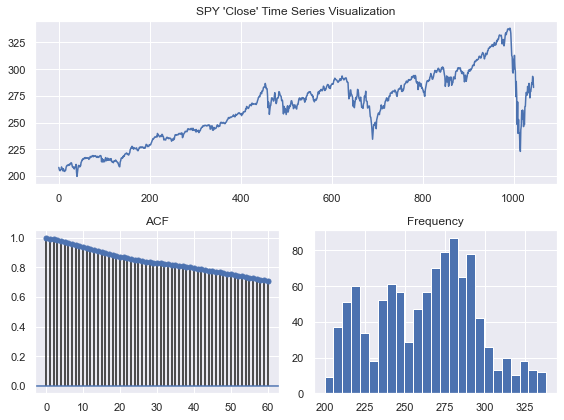

Using DateFeaturizer.
Using FourierFeaturizer.
Parameters for Pipeline: 
[('date', DateFeaturizer(column_name='date')), ('fourier', FourierFeaturizer(k=4, m=261)), ('arima', AutoARIMA(d=1, maxiter=200, seasonal=False, trace=3))]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5303.410, Time=3.40 sec
First viable model found (5303.410)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5375.069, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5322.959, Time=1.79 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5334.625, Time=1.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5373.617, Time=1.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5304.931, Time=2.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5311.676, Time=4.97 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5238.385, Time=3.96 sec
New best model found (5238.385 < 5303.410)
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5257.461, Time=3.07 sec
Near non-invertible roots for order (4, 1, 2)(0, 0, 0,

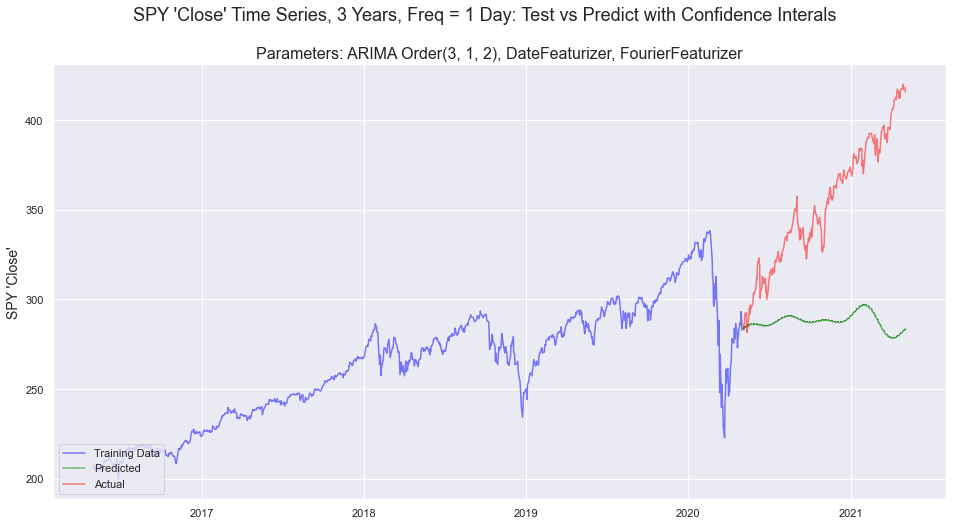

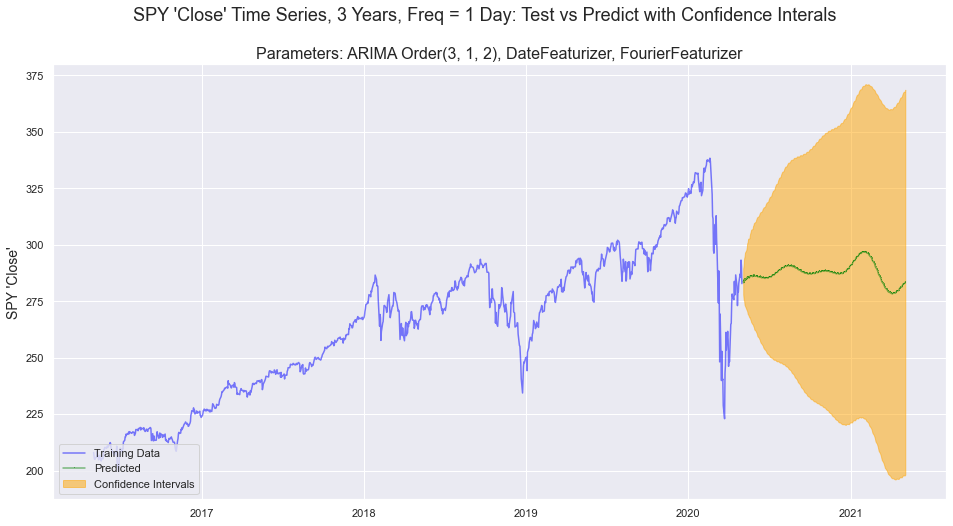

In [530]:
pam_5Y_close = pam_5Y.run_auto_pipeline(show_summary=True, visualize=True)

In [550]:
AIC, RMSE, SMAPE = pam_5Y.run_stepwise_cv(dynamic=False, visualize=True)

Pmdarima_Model.py loaded.
Starting Step-Wise Cross-Validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test .............

KeyboardInterrupt: 

In [ ]:
pam_5Y_best = pam_5Y.run_gridsearch_CV(debug=True)

In [532]:
pam_5Y.conf_ints

[autoreload of Pmdarima_Model failed: Traceback (most recent call last):
  File "/Users/wax/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/wax/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/wax/opt/anaconda3/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/wax/opt/anaconda3/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "../code/Pmda

[array([278.04899961, 289.45345094]),
 array([277.33877241, 288.73736992]),
 array([281.5040356 , 292.90466188]),
 array([278.56602773, 289.9657862 ]),
 array([282.05786671, 293.46138089]),
 array([285.84165327, 297.25329953]),
 array([288.08877167, 299.48904078]),
 array([281.52700572, 292.9664437 ]),
 array([276.81349333, 288.26670766]),
 array([278.27118432, 289.7090436 ]),
 array([280.86929199, 292.31601846]),
 array([288.48492801, 299.97227249]),
 array([287.04778126, 298.52379197]),
 array([291.10115062, 302.58639651]),
 array([288.41105977, 299.89083545]),
 array([291.12903875, 302.6062725 ]),
 array([289.41052179, 300.88065827]),
 array([295.57051984, 307.04734298]),
 array([295.21163933, 306.68661766]),
 array([299.11733285, 310.58426153]),
 array([296.88875734, 308.35480197]),
 array([300.52494407, 311.99152808]),
 array([302.01297072, 313.47527454]),
 array([305.74346513, 317.21792002]),
 array([306.19637617, 317.6480651 ]),
 array([311.75653095, 323.24655447]),
 array([317.

In [502]:
conf_int = np.asarray(pam_5Y.conf_ints)
conf_int

array([[[409.20989353, 421.26538157]],

       [[285.1660225 , 303.76023275]],

       [[269.50048142, 288.23135287]],

       [[270.16008045, 288.76362879]],

       [[288.56716349, 307.20985935]],

       [[270.60474101, 289.26467481]],

       [[297.03331737, 315.72389913]],

       [[267.61470892, 286.37110679]],

       [[280.82712111, 299.62789609]],

       [[268.13826345, 286.92563316]],

       [[282.25829629, 301.05671144]],

       [[282.01409577, 300.81084109]],

       [[285.5600426 , 304.34140626]],

       [[285.88313779, 304.66818434]],

       [[285.63982814, 304.40610074]],

       [[286.94006684, 305.71064717]],

       [[286.63678269, 305.38508813]],

       [[291.83506153, 310.60032539]],

       [[291.61084118, 310.3063045 ]],

       [[295.61558547, 314.37890152]],

       [[293.59231756, 312.28667434]],

       [[297.90140431, 316.67075697]],

       [[297.7753838 , 316.47761816]],

       [[302.81753777, 321.59542314]],

       [[301.80685943, 320.50519636]],



## Last 10 Years, 1 Day

In [102]:
pam_10Y_close = Pmdarima_Model(df_full_10Y_close, 'SPY \'Close\'', train_size=80,
                            n=10, periods='years', freq='1 Day', f_seas=261, seas=261,
                            estimate_diffs=True, impute=False, verbose=1,
                            date=True, fourier=True, box=False, log=False)

Successfully created instance of Class Pmdarima_Model.


Pmdarima_Model.py loaded.
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8171.551, Time=12.96 sec
First viable model found (8171.551)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8174.157, Time=1.83 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8176.157, Time=0.88 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8176.157, Time=1.51 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8176.288, Time=1.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8170.200, Time=12.38 sec
New best model found (8170.200 < 8171.551)
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8175.931, Time=1.54 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8177.685, Time=4.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8171.450, Time=12.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=8177.888, Time=1.80 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8177.820, Time=1.43 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=8174.204, Time=11.51 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=8176.954, Time

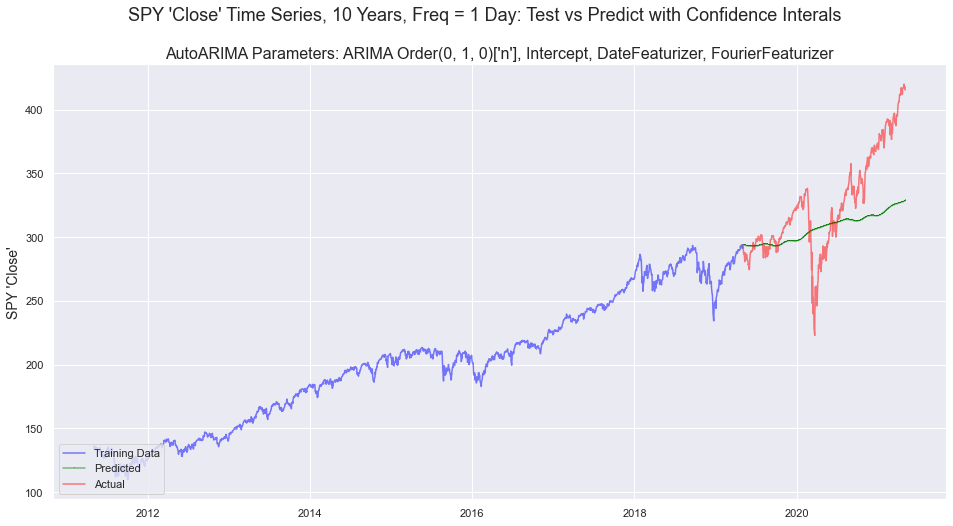

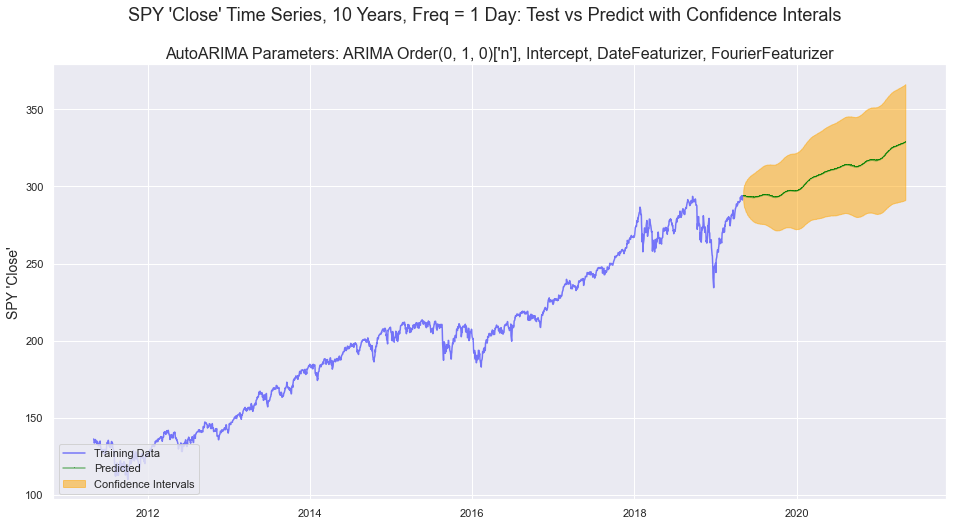

In [90]:
pam_10_pipe = pam_10Y_close.run_auto_pipeline(verbose=0, visualize=True)

In [ ]:
pam_10_pipe = pam_10Y_close.run_auto_pipeline(verbose=0, visualize=True)

### GridSearch

In [107]:
pam_10Y_best, scores = pam_10Y_close.run_gridsearch_CV(max_order=2,
                                                 t_list=['t'],
                                                 fourier=True, box=False, log=False,
                                                 verbose=1, debug=True, parallel=False)

Pmdarima_Model.py loaded.
Starting GridSearchCV...
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(2, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer
Finished building list of 6 models.
Running normally.


_____________________________________________________________________

Starting step-wise cross-validation...


> 
Done.
AIC: 12312.32 | RMSE: 4.55 | SMAPE 0.94
Model[ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12312.321 | RMSE=4.546 | SMAPE=0.944
First viable model found, RMSE=4.546
_____________________________________________________________________

Starting step-wise cross-validation...


> 
Done.
AIC: 12294.24 | RMSE: 4.53 | SMAPE 0.94
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12294.240 | RMSE=4.531 | SMAPE=0.938
Next best model found, RMSE=4.531
_____________________________________________________________________

Starting step-wise cross-validation...


> 
Done.
AIC: 12230.52 | RMSE: 4.49 | SMAPE 0.93
Model[ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12230.519 | RMSE=4.490 | SMAPE=0.933
Next best model found, RMSE=4.490
_____________________________________________________________________

Starting step-wise cross-validation...


> 
Done.
AIC: 12254.54 | RMSE: 4.51 | SMAPE 0.94
Model[ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12254.538 | RMSE=4.512 | SMAPE=0.936
_____________________________________________________________________

Starting step-wise cross-validation...


> 
Done.
AIC: 12244.82 | RMSE: 4.47 | SMAPE 0.93
Model[ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12244.817 | RMSE=4.473 | SMAPE=0.931
Next best model found, RMSE=4.473
_____________________________________________________________________

Starting step-wise cross-validation...


> 
Done.
AIC: 12236.19 | RMSE: 4.51 | SMAPE 0.94
Model[ARIMA Order(2, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12236.189 | RMSE=4.514 | SMAPE=0.937

GridsearchCV Completed.

Top 10 models:
Model[ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12244.817 | RMSE=4.473 | SMAPE=0.931
Model[ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12230.519 | RMSE=4.490 | SMAPE=0.933
Model[ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12254.538 | RMSE=4.512 | SMAPE=0.936
Model[ARIMA Order(2, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12236.189 | RMSE=4.514 | SMAPE=0.937
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12294.240 | RMSE=4.531 | SMAPE=0.938
Model[ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12312.321 | RMSE=4.546 | SMAPE=0.944


In [ ]:
AIC, RMSE, SMAPE = pam_10Y_close.run_stepwise_CV(pam_10Y_best, func='GS', dynamic=False, verbose=1, visualize=True)

Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='t'))])
Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


In [ ]:
AIC, RMSE, SMAPE = pam_10Y_close.run_stepwise_CV(pam_10Y_best, func='GS', dynamic=True, verbose=1, visualize=True)

In [132]:
pam_10Y_close.y_hat[0] = 313.45345261

Pmdarima_Model.py loaded.


In [131]:
y_back

[415.40681030003304,
 306.49202007813415,
 285.39211671784716,
 288.39298991096564,
 286.2901450573864,
 287.926495242722,
 281.70120762923943,
 283.24709434965666,
 284.9527905062954,
 287.3790223139383,
 285.8714354571563,
 284.30609016147616,
 286.5012211910292,
 285.6421509796076,
 282.2123658685774,
 282.47438819424366,
 281.87538305051345,
 280.39149549516713,
 278.25156443405024,
 278.77976469759403,
 275.7416131108612,
 274.8009625480526,
 280.2775913749428,
 282.7785509808792,
 284.51584853958536,
 287.2787083482318,
 289.18975367292984,
 289.10179957034194,
 288.278594843079,
 289.3306149563679,
 289.12297177314787,
 289.6119055721473,
 292.3388078289075,
 292.95771889395934,
 295.5117157498364,
 294.02800580883746,
 293.8843937431715,
 291.20182274089655,
 290.30249779086165,
 291.32486345844256,
 293.1786768785967,
 295.8320979637468,
 296.64808844809835,
 298.532747620775,
 298.5965898448829,
 298.2954131944492,
 297.2620495315334,
 297.36097038516147,
 298.4421344667728,


In [143]:
pam_10Y_close.conf_ints[0] = [305.31391322615, 317.230668683994]

In [142]:
pam_10Y_close.conf_ints

[[305.31391322615, 417.230668683994],
 [298.32023128430285, 314.66380887196544],
 [277.19412341747534, 293.590110018219],
 [280.1949963290121, 296.5909834929192],
 [278.09215147543284, 294.4881386393399],
 [279.7285016607685, 296.12448882467555],
 [273.5032140094493, 289.89920124902955],
 [275.04910072986655, 291.4450879694468],
 [276.7547968865053, 293.1507841260855],
 [279.1810286941482, 295.57701593372843],
 [277.67344183736617, 294.0694290769464],
 [276.10809654168605, 292.5040837812663],
 [278.30322757123906, 294.6992148108193],
 [277.4441573598175, 293.8401445993977],
 [274.0143722487873, 290.41035948836753],
 [274.27639457445355, 290.67238181403377],
 [273.67738943072334, 290.07337667030356],
 [272.1935018649229, 288.5894891254114],
 [270.05357076839346, 286.449558099707],
 [270.58177103193725, 286.9777583632508],
 [267.5436194103827, 283.9396068113397],
 [266.60296884114996, 282.99895625495526],
 [272.07959766804015, 288.47558508184545],
 [274.5805572739765, 290.9765446877818],

Pmdarima_Model.py loaded.


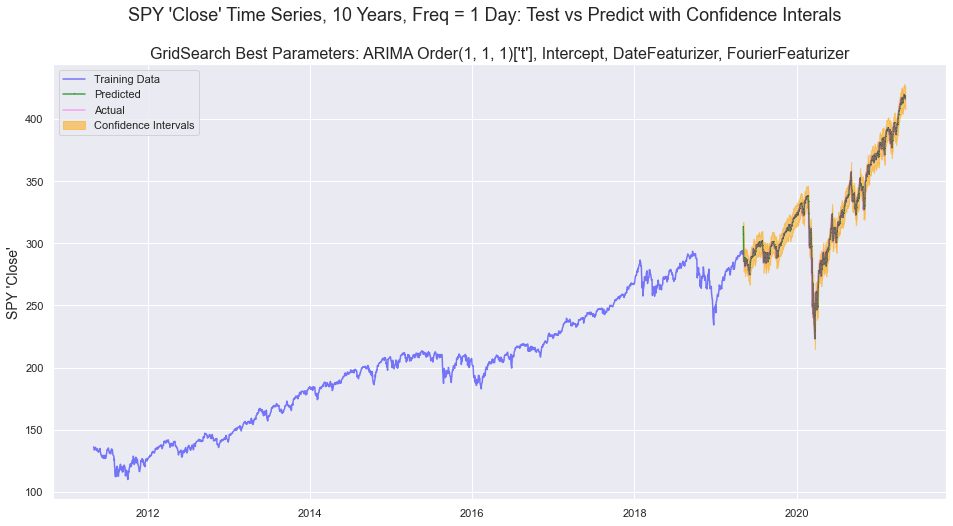

In [152]:
pam_10Y_close.plot_test_predict(pam_10Y_close.y_hat, func='GS', conf_ints=pam_10Y_close.conf_ints)

In [ ]:
AIC, RMSE, SMAPE = pam_10Y_close.run_stepwise_CV(pam_10Y_close.GS_best_mod_pipe, dynamic=False, verbose=1, visualize=True)

### Close Only

In [99]:
pam_10Y_close = pm.pipeline.Pipeline(steps=[('date', pm.preprocessing.DateFeaturizer(column_name='date')),
                ('fourier', pm.preprocessing.FourierFeaturizer(k=4, m=261)),
                ('arima',
                 pm.ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='t'))])

In [385]:
pam_10Y_close.fit(df_full_10Y_close, dates_10Y)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12225.142, Time=8.31 sec
First viable model found (12225.142)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12305.715, Time=2.88 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12247.876, Time=1.61 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12257.882, Time=2.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12308.296, Time=2.74 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12225.900, Time=4.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12230.283, Time=5.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=12138.859, Time=9.43 sec
New best model found (12138.859 < 12225.142)
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=12172.905, Time=6.73 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=12168.330, Time=17.89 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=12209.742, Time=18.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=12214.116, Time=13.49 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=12219.083, Time=7.40 sec
 

Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=3))])

In [521]:
# close_hat, close_conf_ints = pam_10Y_close.predict(X=new_dates_df, return_conf_int=True)
close_hat, close_conf_ints = pam_10Y_close.predict(X=date_df, return_conf_int=True)
close_hat

array([414.12253109])

In [523]:
close_conf_ints

array([[409.31738871, 418.92767348]])

### Volume

In [355]:
pam_10Y_vol = exog_pipe

In [ ]:
pam_10Y_vol.fit(df_full_10Y_vol, dates_10Y)

In [ ]:
vol_hat, vol_conf_ints = pam_10Y_vol.predict(X=new_dates_df, return_conf_int=True)
vol_hat

In [ ]:
vol_hat_df = pd.DataFrame(vol_hat, index=index_fc, columns=['volume'])
vol_hat_df = vol_hat_df.join(new_dates_df)
vol_hat_df

In [96]:
train, test = pm.model_selection.train_test_split(df_full_10Y_close, train_size=80/100)
X_train = pd.DataFrame(train.index)
y_train = train.values
# X_test = pd.DataFrame(test.index)
X_test = pd.DataFrame(test.index, index=range(X_train.size, pam_10Y_close.length))
y_test = test.values

X_test

,date
2090,2019-05-06
2091,2019-05-07
2092,2019-05-08
2093,2019-05-09
2094,2019-05-10
...,...
2608,2021-04-29
2609,2021-04-30
2610,2021-05-03
2611,2021-05-04


Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='c'))])
Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
Test AIC: 915.937
Test RMSE: 29472989.242
This is 24.645% of the avg observed value.
Test SMAPE: 22.399%



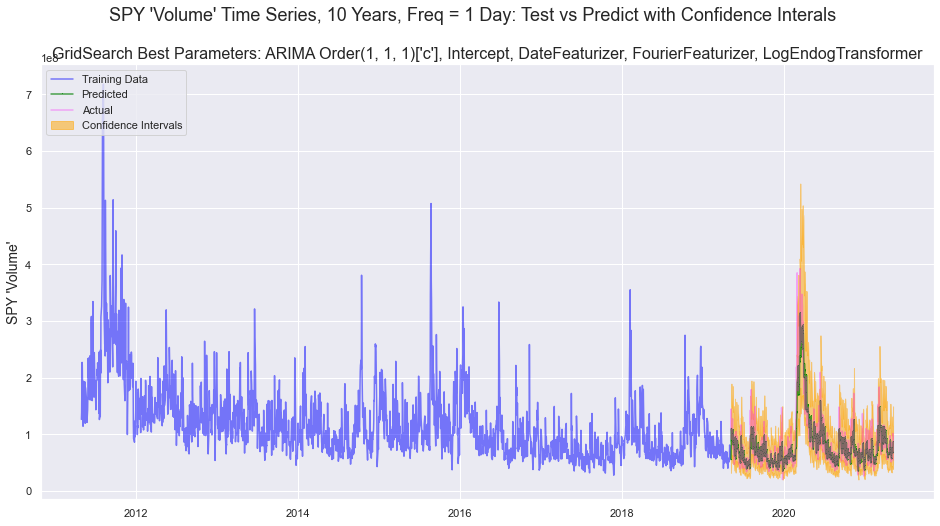

In [267]:
AIC, RMSE, SMAPE = pam_10Y_vol.run_stepwise_CV(pam_3Y_vol_best, func='GS', dynamic=False, verbose=1, visualize=True)

TypeError: cannot unpack non-iterable NoneType object

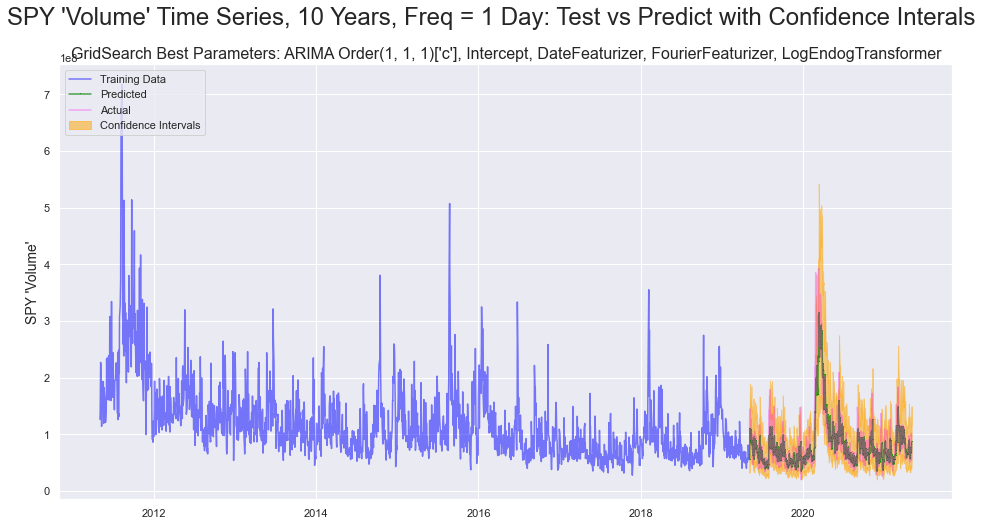

In [271]:
AIC, RMSE, SMAPE = pam_10Y_vol.plot_test_predict(y_hat=pam_10Y_vol.y_hat, conf_ints=pam_10Y_vol.conf_ints, func='GS')

In [97]:
date_feat = pm.preprocessing.DateFeaturizer(
    column_name="date",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)
_, X_train_feats = date_feat.fit_transform(y_train, X_train)
# _, X_train_feats = date_feat.fit_transform(df_full_10Y_close, dates_10Y)

In [54]:
date_feat = pm.preprocessing.DateFeaturizer(
    column_name="date",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)
# _, X_train_feats = date_feat.fit_transform(y_train, X_train)
_, X_train_feats = date_feat.fit_transform(df_full_10Y_close, dates_10Y)
full_10Y_pipe = pipeline.Pipeline([
    ('date', date_feat),
    ("fourier", pm.preprocessing.FourierFeaturizer(m=261, k=4)),
    ('arima', pm.arima.AutoARIMA(d=1,
                                 trace=3,
                                 stepwise=True,
                                 suppress_warnings=True,
                                 seasonal=False))
])

NameError: name 'dates_10Y' is not defined

In [389]:
vol_10Y_df = pd.DataFrame(df_full_10Y_vol).reset_index()

In [390]:
full_10Y_pipe.fit(df_full_10Y_close, vol_10Y_df)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11946.779, Time=4.67 sec
First viable model found (11946.779)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12049.260, Time=3.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11967.924, Time=2.95 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11983.657, Time=3.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29984.283, Time=2.64 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11948.396, Time=4.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11964.263, Time=4.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11927.898, Time=6.58 sec
New best model found (11927.898 < 11946.779)
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11950.471, Time=6.00 sec


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning:

divide by zero encountered in reciprocal

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=12065.322, Time=5.28 sec


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning:

divide by zero encountered in reciprocal

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=12066.598, Time=4.96 sec


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning:

divide by zero encountered in reciprocal

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=12064.301, Time=4.84 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=11936.817, Time=4.96 sec


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning:

divide by zero encountered in reciprocal

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=12071.707, Time=5.36 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=11929.051, Time=4.72 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0] intercept
Total fit time: 68.143 seconds


Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima', AutoARIMA(d=1, seasonal=False, trace=3))])

In [391]:
close_vol_hat, close_vol_conf_ints = full_10Y_pipe.predict(X=vol_hat_df, return_conf_int=True)
close_vol_hat

array([414.79630855, 414.60707979, 414.48872733, 414.77080045,
       414.65227317])

In [203]:
close_vol_hat = np.asarray([414.79630855, 414.60707979, 414.48872733, 414.77080045,
       414.65227317])

In [392]:
Audio(sound_file, autoplay=True)

### Plot

In [156]:
spy_df_10Y[-120:].shape

(120, 6)

NameError: name 'new_fc_df' is not defined

In [ ]:
new_fc_df = pd.DataFrame(zip(new_dates_df.date.values,close_vol_hat), columns=['date','close'])
new_fc_df.set_index('date', inplace=True)

In [ ]:
spy_df_10Y_fc = spy_df_10Y.append(new_fc_df)

In [199]:
121//20

6

In [205]:
new_fc_df = pd.DataFrame(zip(new_dates_df.date.values,close_vol_hat), columns=['date','close'])
new_fc_df.set_index('date', inplace=True)
spy_df_10Y_fc = spy_df_10Y.append(new_fc_df)
spy_df_10Y_fc

,open,high,low,close,adj_close,volume
date,,,,,,
2011-05-02,137.070007,137.179993,135.949997,136.220001,111.753159,126278700.0
2011-05-03,135.960007,136.190002,135.039993,135.729996,111.351181,138375000.0
2011-05-04,135.669998,135.729996,134.229996,134.830002,110.612801,182678500.0
2011-05-05,134.080002,134.949997,133.020004,133.610001,109.611984,226900000.0
2011-05-06,134.940002,135.630005,133.679993,134.199997,110.096001,222787200.0
...,...,...,...,...,...,...
2021-05-06,NaN,NaN,NaN,414.796309,NaN,NaN
2021-05-07,NaN,NaN,NaN,414.607080,NaN,NaN
2021-05-10,NaN,NaN,NaN,414.488727,NaN,NaN


In [212]:
spy_df_10Y_fc.index[-120] + cbd

Timestamp('2020-11-27 00:00:00')

Pmdarima_Model.py loaded.


NameError: name 'spy_df_10Y_fc' is not defined

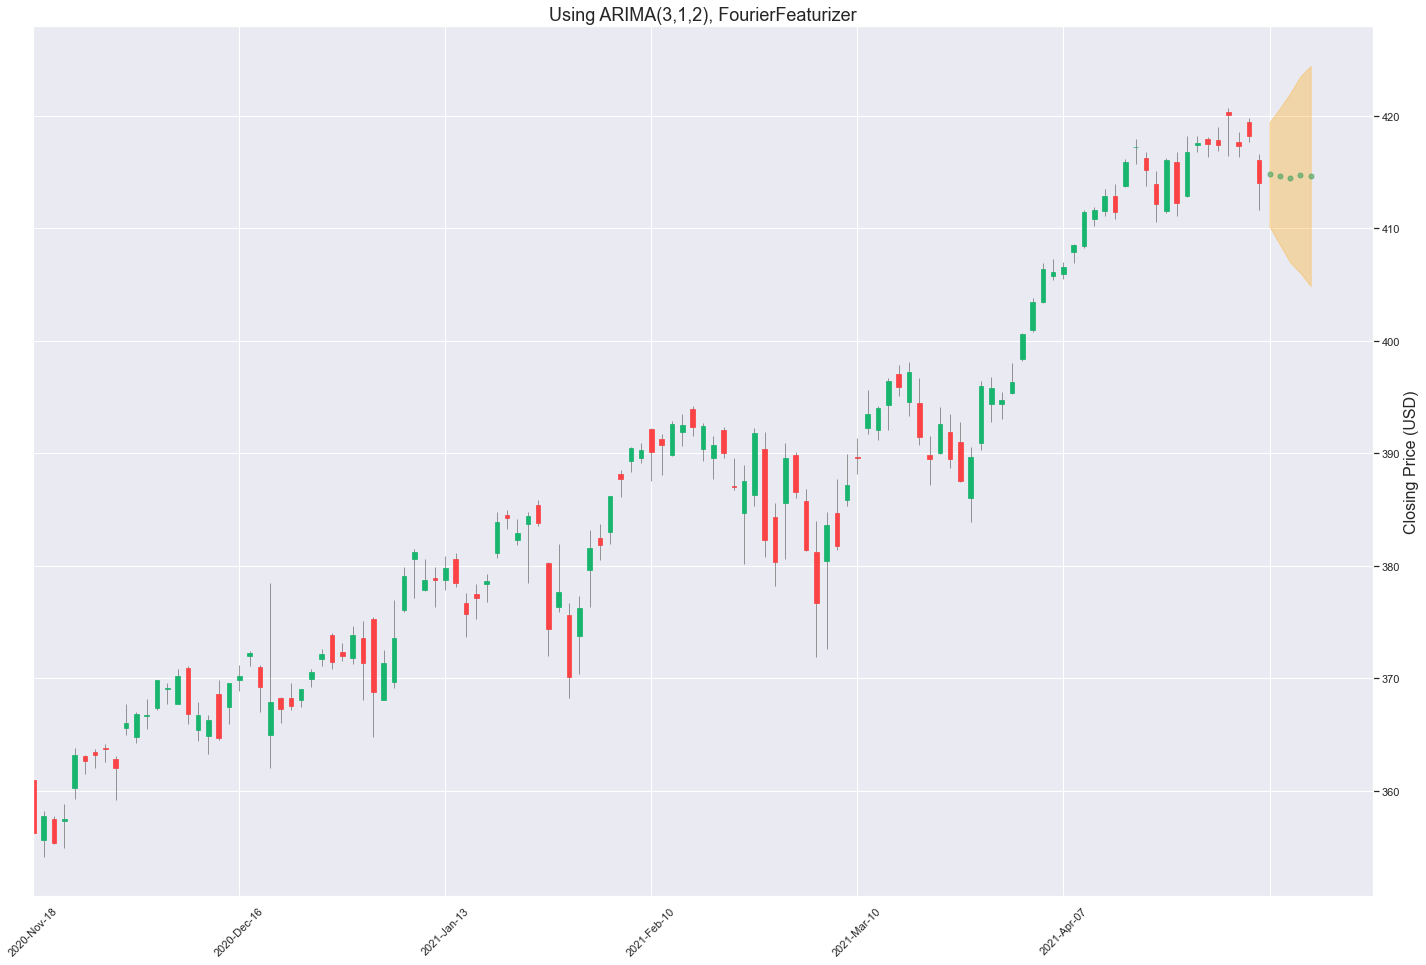

In [525]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(24, 16))
mpl.plot(spy_df_10Y[-120:],
         type='candle',
         style="yahoo",
         ax=ax,
         )
ax.plot(range(120,125), close_vol_hat, 'g.', markersize=10, alpha=0.7, label='Forecast')
# conf_int = np.asarray(close_vol_conf_ints)
conf_int = close_vol_conf_ints
ax.fill_between(range(120,125),
         conf_int[:, 0], conf_int[:, 1],
         alpha=0.3, color='orange',
         label="Confidence Intervals")
ax.set_xlim(0, 130)
ax.set_ylabel('Closing Price (USD)', size=16)
ax.set_title('Using ARIMA(3,1,2), FourierFeaturizer', size=18)
equidate_ax(fig, ax, spy_df_10Y_fc[-125:].index.date)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
fig.subplots_adjust(top=0.92)
ax.legend(loc='upper left', borderaxespad=0.5, fontsize = 18)
fig.suptitle(f'{ylabel} Time Series, 10 Years, Freq = 1 Day: Historical vs Forecast with Confidence Interals\n', size=24)

In [170]:
new_df = pd.DataFrame(df_full_10Y_vol)
new_df

,volume
date,
2011-05-02,126278700.0
2011-05-03,138375000.0
2011-05-04,182678500.0
2011-05-05,226900000.0
2011-05-06,222787200.0
...,...
2021-04-29,78544300.0
2021-04-30,85448400.0
2021-05-03,68128300.0


### Programmatically Forecasting

In [237]:
pam_10Y_best

Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='t'))])

Successfully created instance of Class Pmdarima_Model.
Running Fit and Predict on Exogenous variable SPY 'Volume'...
Successfully fit model on historical observations.
Successfully forecasted 12 days forward.


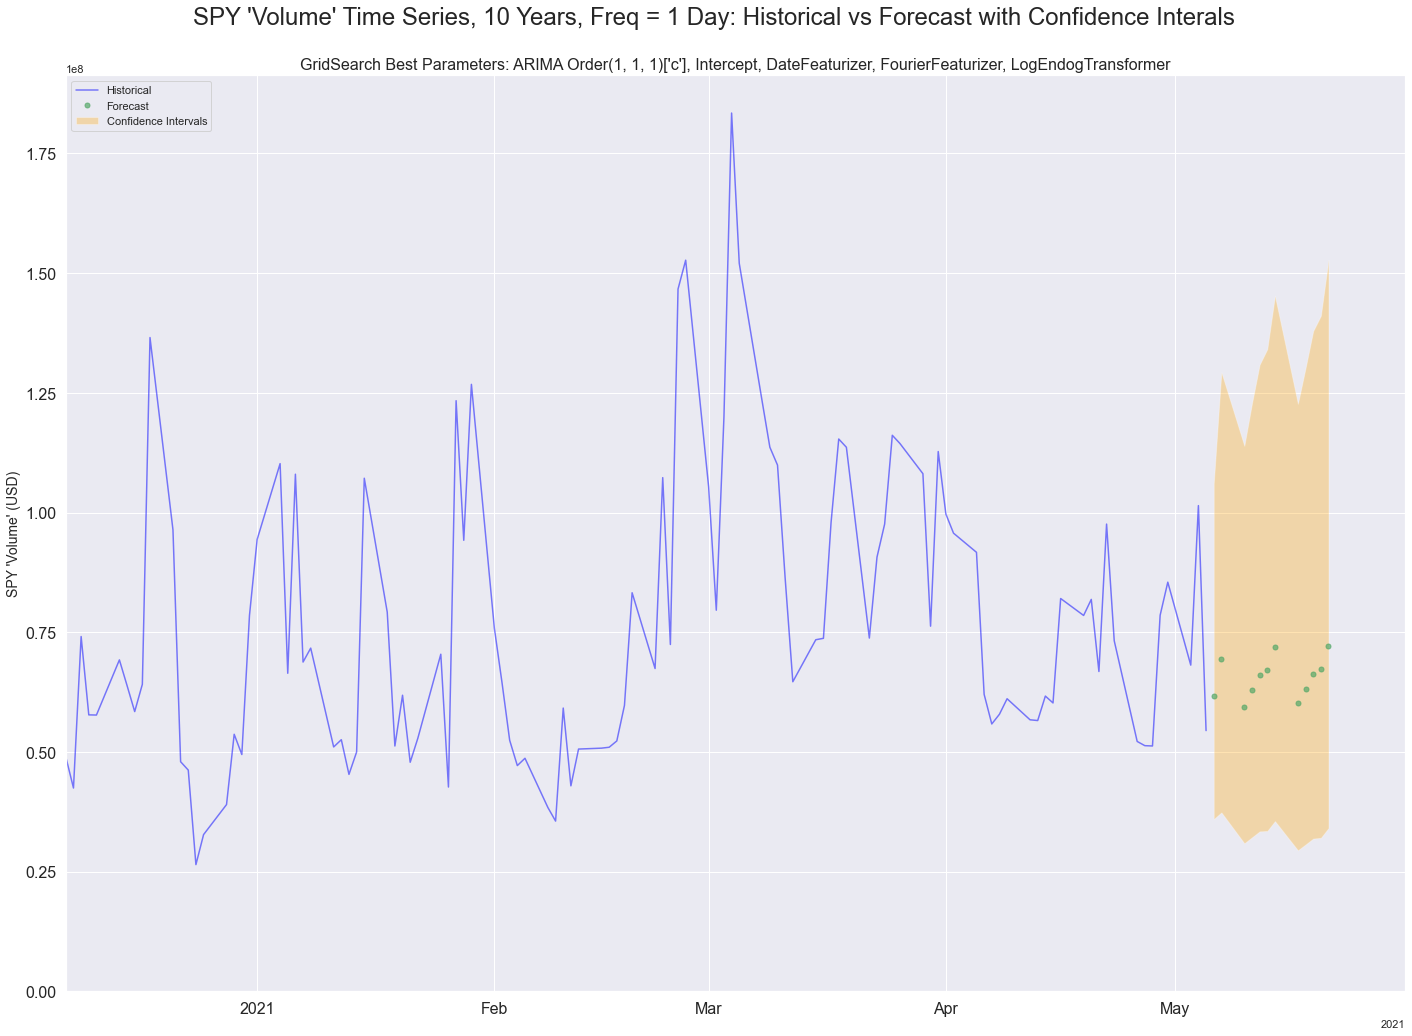

In [246]:
pam_10Y_vol = Pmdarima_Model(df_full_10Y_vol, 'SPY \'Volume\'', train_size=80, start_order=(1,1,1),
                            n=10, periods='years', freq='1 Day', f_seas=261, seas=261, trend='c',
                            estimate_diffs=True, impute=False, verbose=1,
                            date=True, fourier=True, box=False, log=True)
vol_10Y_hat_df, vol_10Y_hat, new_dates_df, vol_10Y_conf_ints = pam_10Y_vol.run_prediction(pam_3Y_vol_best, 12, fin=False,
                            en_ex='exog', hist_df=df_full_10Y_vol, func='GS', verbose=1)

In [247]:
exog_df = Pmdarima_Model.join_exog_data(new_dates_df, vol_10Y_hat_df)

Successfully created instance of Class Pmdarima_Model.
Running Fit and Predict on Endogenous variable SPY 'Close'...
Successfully fit model on historical observations.
Successfully forecasted 12 days forward.


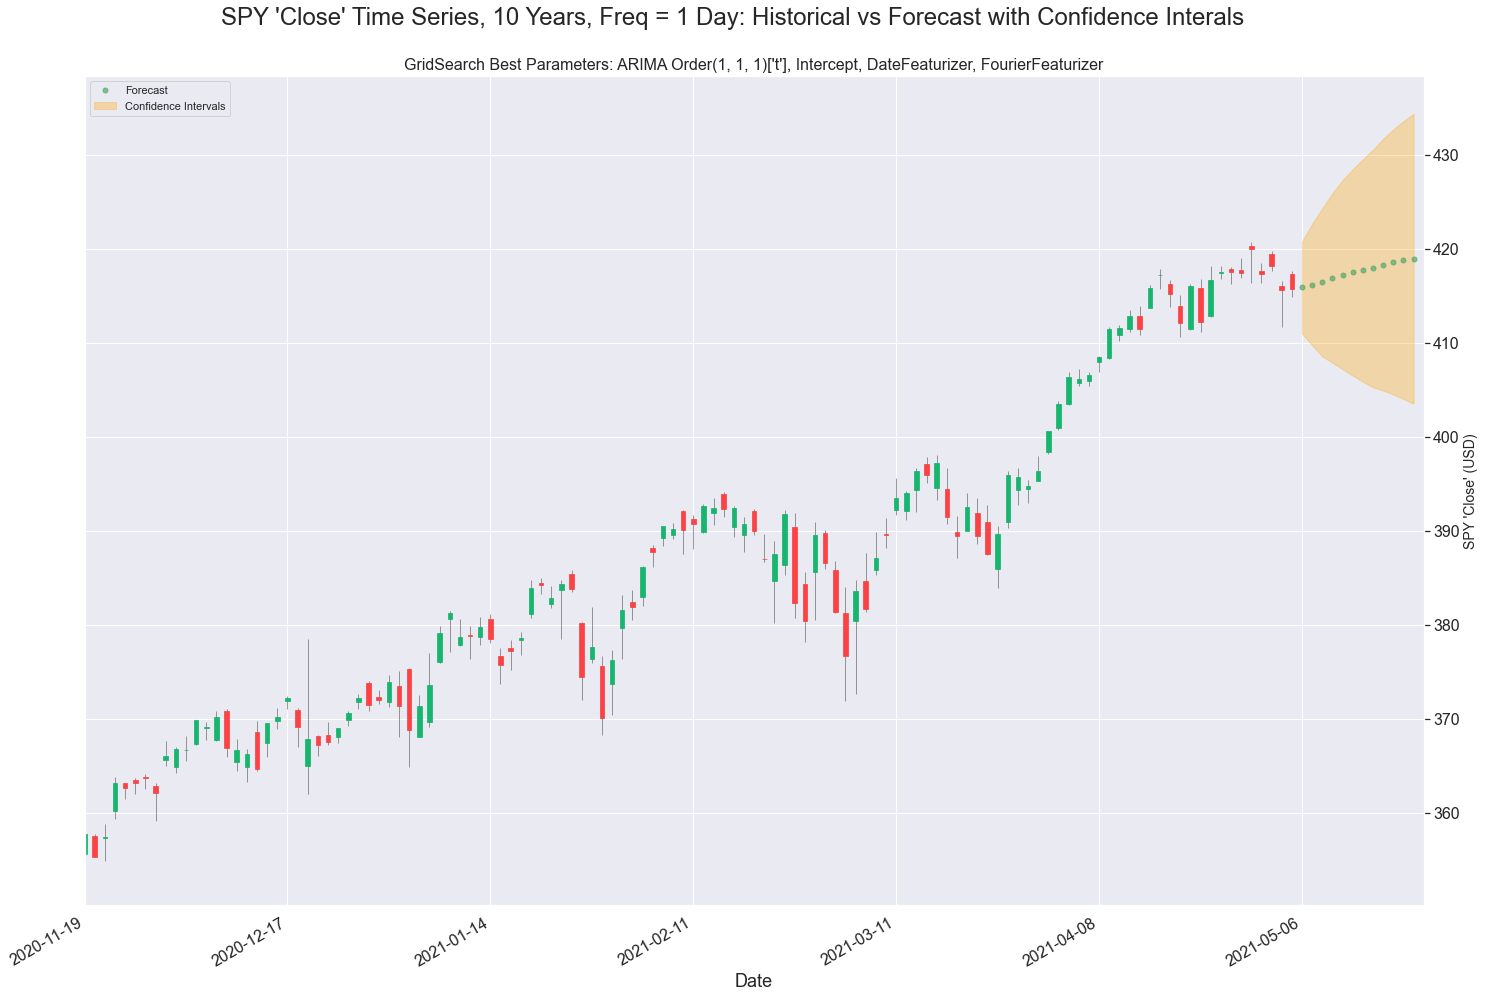

In [248]:
pam_10Y_close = Pmdarima_Model(df_full_10Y_close, 'SPY \'Close\'', train_size=80, start_order=(1,1,1),
                            n=10, periods='years', freq='1 Day', f_seas=261, seas=261, trend='t',
                            estimate_diffs=True, impute=False, verbose=1,
                            date=True, fourier=True, box=False, log=False)
close_10Y_hat_df, close_10Y_hat, new_dates_df, close_10Y_conf_ints = pam_10Y_close.run_prediction(pam_10Y_best, 12, fin=True,
                            exog_df=exog_df, en_ex='endo', ohlc_df=spy_df_10Y, func='GS', verbose=1)

### Stepwise CV

In [437]:
date_feat = pm.preprocessing.DateFeaturizer(
    column_name="date",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)
_, X_train_feats = date_feat.fit_transform(y_train, X_train)
full_10Y_pipe = pipeline.Pipeline([
    ('date', date_feat),
    ("fourier", pm.preprocessing.FourierFeaturizer(m=261, k=4)),
    ('arima', pm.arima.AutoARIMA(d=1,
                                 trace=3,
                                 stepwise=True,
                                 suppress_warnings=True,
                                 seasonal=False))
])

DatetimeIndex(['2011-05-02', '2011-05-03', '2011-05-04', '2011-05-05',
               '2011-05-06', '2011-05-09', '2011-05-10', '2011-05-11',
               '2011-05-12', '2011-05-13',
               ...
               '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-26',
               '2021-04-27', '2021-04-28', '2021-04-29', '2021-04-30',
               '2021-05-03', '2021-05-04'],
              dtype='datetime64[ns]', name='date', length=2612, freq='C')

In [453]:
X_test

,date
2089,2019-05-03
2090,2019-05-06
2091,2019-05-07
2092,2019-05-08
2093,2019-05-09
...,...
2607,2021-04-28
2608,2021-04-29
2609,2021-04-30
2610,2021-05-03


In [454]:
# full_10Y_pipe.fit(df_full_10Y_close.values, pd.DataFrame(df_full_10Y_close.index))
# full_10Y_pipe.fit(df_full_10Y_close.values, dates_10Y)
full_10Y_pipe.fit(y_test, X_test)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3051.921, Time=1.07 sec
First viable model found (3051.921)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3090.663, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3059.319, Time=1.00 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3067.151, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3090.010, Time=0.59 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3050.890, Time=0.85 sec
New best model found (3050.890 < 3051.921)
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3049.213, Time=0.79 sec
New best model found (3049.213 < 3050.890)
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3050.648, Time=1.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3057.010, Time=0.65 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3050.165, Time=2.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3048.629, Time=0.78 sec
New best model found (3048.629 < 3049.213)
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3067.371, Time=0.66 sec


Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima', AutoARIMA(d=1, seasonal=False, trace=3))])

In [373]:
dates_10Y

,date
0,2011-05-02
1,2011-05-03
2,2011-05-04
3,2011-05-05
4,2011-05-06
...,...
2607,2021-04-28
2608,2021-04-29
2609,2021-04-30
2610,2021-05-03


In [398]:
X_test

,date
2089,2019-05-03
2090,2019-05-06
2091,2019-05-07
2092,2019-05-08
2093,2019-05-09
...,...
2607,2021-04-28
2608,2021-04-29
2609,2021-04-30
2610,2021-05-03


In [462]:
date_df = X_test[0:1]
date_df

,date
2089,2019-05-03


In [463]:
date_df.date.iloc[0] + cbd

Timestamp('2019-05-06 00:00:00')

In [464]:
model = full_10Y_pipe
dynamic = False

def forecast_one_step(date_df):
    fc, conf_int = model.predict(X=date_df, return_conf_int=True)
#     fc, conf_int = model.predict_in_sample(X=dates_10Y, len)
    return (
        #         fc.tolist()[0],
        fc[0],
        #         np.asarray(conf_int).tolist()[0])
        conf_int
    )

# date_df = pd.DataFrame([df_full_10Y_close.index[0]], columns=['date'])
date_df = X_test[0:1]

forecasts = []
conf_ints = []
print(f'Iteratively making predictions on SPY \'Close\' Time Series and updating model, beginning at 0 ...', end='')
# for new_ob in df_full_10Y_close:
# for new_ob in tqdm(range(len(y_test))):
for new_ob in tqdm(y_test):
    fc, conf = forecast_one_step(date_df)
    forecasts.append(fc)
    conf_ints.append(conf)

    # Updates the existing model with a small number of MLE steps
#     if dynamic == True:
#         model.update([fc], date_df)
#     elif dynamic == False:
    model.update([new_ob], date_df)
#     print('.', end='')
    # date = pd.DataFrame([X_test.iloc[0].date + cbd], index=[X_train.size]columns=['date'])
#     date_df.iloc[0].date += cbd
    date_df.date.iloc[0] + cbd
    date_df.index += 1
    # date += cbd
print(' Done.')
# y_hat = pd.Series(forecasts, index=y_test.index)
y_hat = forecasts

  0%|          | 0/523 [00:00<?, ?it/s]

Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning at 0 ...

100%|██████████| 523/523 [06:47<00:00,  1.28it/s]

 Done.


In [465]:
y_test.size

523

In [466]:
y_hat

[521.2634027937833,
 293.7971242569228,
 290.9512521431911,
 287.14608588420515,
 286.73630703110746,
 285.8958137368,
 287.3502156851442,
 280.14792564975147,
 282.65279208473805,
 284.42414058102065,
 287.0964858376716,
 285.29174763435884,
 283.419594645526,
 286.0369856601986,
 285.24562319295285,
 281.79864844468864,
 282.4870163028117,
 281.280082744747,
 280.0261007730082,
 278.22901502046824,
 279.0618761300209,
 275.4128892792394,
 274.7590691542435,
 280.8237314975987,
 283.39144351800496,
 285.2810241774091,
 288.2076189313098,
 289.6120868355195,
 289.60464051173955,
 289.1516039102724,
 290.4075410041136,
 290.15989165244275,
 290.3123443304427,
 293.3921293869245,
 294.1130416621904,
 296.93150423966443,
 295.11345881419516,
 294.74169857628596,
 291.8865624253717,
 291.5804830846724,
 292.638419130593,
 294.1367730410157,
 296.78218903116345,
 297.5373844107805,
 299.8726383641599,
 299.67590174656453,
 299.44385350584076,
 297.75691388622477,
 298.05854428290087,
 299.4

In [467]:
# RMSE = mse(df_full_10Y_close, y_hat, squared=False)
RMSE = mse(test, y_hat, squared=False)
print("Test RMSE: %.2f" % RMSE)
print("This is %.2f%% of the avg observed value." % (100*RMSE/y_train.mean()))
print("Test SMAPE: %.2f%%\n" % smape(test, y_hat))
# print("Test SMAPE: %.2f%%\n" % smape(df_full_10Y_close, y_hat))

Test RMSE: 10.95
This is 5.46% of the avg observed value.
Test SMAPE: 1.07%



In [468]:
fc, conf_ints = model.predict(X=new_dates_df, return_conf_int=True)

In [469]:
fc

array([416.95933521, 413.52184596, 409.9202409 , 406.34035504,
       406.80537236])

In [470]:
conf_ints

array([[392.61884771, 441.2998227 ],
       [379.31263146, 447.73106046],
       [367.90927322, 451.93120859],
       [357.76492447, 454.9157856 ],
       [352.4526033 , 461.15814141]])

In [460]:
Audio(sound_file, autoplay=True)

In [ ]:
df_train, df_test, vol_train, vol_test = pdarima_fit_predict(df_full_10Y_close, df_full_10Y_vol, 'SPY \'Close\'', 'SPY \'Volume\'',
                                                             n=10, period='years', freq='1 Day', seas=261,
                                                             train_size=80, impute=1, verbose=1, extra=1)

In [ ]:
y, X = load_date_example()
y_train, y_test, X_train, X_test = \
    pm.model_selection.train_test_split(y, X, test_size=20)

In [ ]:
df_full_10Y_close.isna().sum()

### Manual

In [ ]:
# df_train, df_test = train_test_split_data(df_full_10Y_close, 80, verbose=1)
df_train, df_test = train_test_split_data(df_full_3Y_close, 80, verbose=1)

In [ ]:
df_train.interpolate()

In [ ]:
new_mod = pm.auto_arima(df_train.interpolate())

In [ ]:
new_mod = pm.auto_arima(df_train.interpolate())

In [ ]:
new_mod.summary()

In [ ]:
new_mod.fit(df_train.interpolate())

In [ ]:
new_mod.summary()

In [ ]:
y_hat_train, conf_int_train = new_mod.predict(typ='levels', dynamic=False, return_conf_int=True)
y_hat_test, conf_int_test = new_mod.predict(start=df_test.index[0], end=df_test.index[-1], typ='levels', return_conf_int=True)

In [ ]:
y_hat_test

NameError: name 'y_hat_train' is not defined

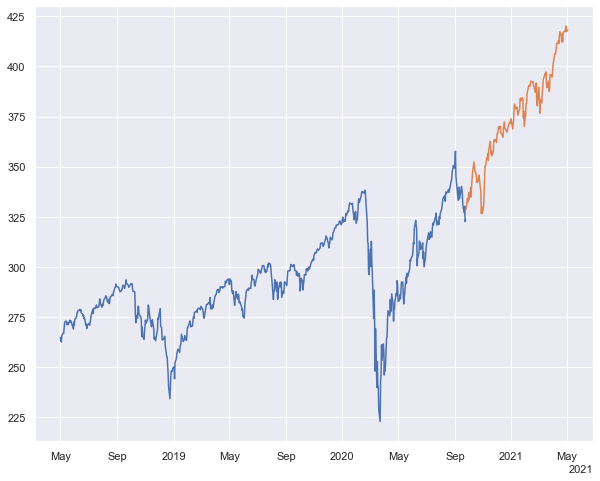

In [510]:
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(df_train, label='Train')
ax.plot(df_test, label='Test')
ax.plot(y_hat_train[1:], label='Train Predictions')
ax.plot(y_hat_test, label='Test Predictions')
ax.set_title('SPY Close Price: Train/Test v Predictions In-Sample')
plt.setp(ax.xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
plt.legend()